In [1]:
import csv
import pickle
import json
import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from mouselab.mouselab import MouselabEnv
import statsmodels
import statsmodels.api as sm
import statsmodels.formula.api as smf
import scipy
import math
import sklearn.cluster
from math import floor, ceil

# Reading Data from Files

The anonymized participant data can be found on the OSF repository for this project in the folder 'anonymized_data'. The files in this folder must be downloaded and copied into the 'results' folder of this GitHub repository. Then, the remainder of the cells in the notebook can be executed.

In [2]:
fileprefix = "final" # pilot_#, final
datafolder = '../results/'

all_part_files = [filename for filename in os.listdir(datafolder) if filename.startswith(fileprefix) and 'results' not in filename]
all_part_paths = [datafolder + filename for filename in all_part_files]

# Creating Trial Dataframe

In [3]:
# Each participant has their own file, generated from the Heroku postgres output in the 
# preprocessing notebook

part_stats_dicts = []
scarcity_level = 0.25
for file in all_part_paths:
    with open(file, 'r') as f:
        participant = json.load(f)
    try:
        beginhit = datetime.datetime.strptime(participant['Beginhit'], '%Y-%m-%d %H:%M:%S.%f')
    except TypeError:
        beginhit = None
    try:
        endhit = datetime.datetime.strptime(participant['Endhit'], '%Y-%m-%d %H:%M:%S.%f')
    except TypeError:
        endhit = None
    try:    
        beginexp = datetime.datetime.strptime(participant['Beginexp'], '%Y-%m-%d %H:%M:%S.%f')
    except TypeError:
        beginexp = None
    
    try:
        hitLength = (endhit-beginhit).seconds
    except TypeError:
        hitLength = None
    
    try:
        expLength = (endhit-beginexp).seconds
    except TypeError:
        expLength = None
        
    numPracTrials = 0
    trialLengths = []
    trialScores = []
    expectedScores = []
    numClicks = []
    avgClickLevel = []
    rewardsWithheld = []
    demographicsAvailable = False
    effort = "-1"
    age = None
    gender = None
    colorblind = None
    
    print(participant['workerId'])
    try:
        firstTrialStamp = participant['data'][0]['dateTime']
    except:
        print("No data")
        continue
    lastTrialStamp = participant['data'][-1]['dateTime']
    if hitLength is None:
        hitLength = (lastTrialStamp - firstTrialStamp) / 1000
    if expLength is None:
        expLength = (lastTrialStamp - firstTrialStamp) / 1000
        
    # Dictionary to check whether stroop tasks have been completed
    stroop_timestamps = {
        "1" : {
            "start" : 0,
            "end" : 0,
            "done" : False
        },
        "2" : {
            "start" : 0,
            "end" : 0,
            "done" : False
        }
    }
    # Dictionary to check whether mouselab task has been completed
    mdp_timestamps = {
        "start" : 0,
        "end" : 0,
        "done": False
    }
    
    # Use state machine to parse participant trial data, update state 
    #  based on trials seen
    current_state = "stroop_1"
    stroop1Completed = 0
    stroop1Correct = 0
    stroop2Completed = 0
    stroop2Correct = 0
    last_trial = participant['data'][0]
    feedback = ""
    comments = ""
    for idx, trial in enumerate(participant['data']):
        trial_type = trial['trialdata']['trial_type']
        try:
            trial_id = str(trial['trialdata']['trial_id'])
        except KeyError:
            trial_id = ""
        
        # Start 1st stroop task
        if trial_id == "stroop_1_ready_1" and not stroop_timestamps["1"]["done"]:
            stroop_timestamps["1"]["start"] = trial['dateTime']
        
        # Start 2nd stroop task
        if trial_id == "stroop_2_ready_1" and not stroop_timestamps["2"]["done"]:
            stroop_timestamps["2"]["start"] = trial['dateTime']
        
        # Finish 1st stroop task
        if trial_id == "finish_distractor_1" and not stroop_timestamps["1"]["done"]:
            stroop_timestamps["1"]["end"] = trial['dateTime']
            stroop_timestamps["1"]["done"] = True
        
        # Finish 2nd stroop task
        if trial_id == "finish_distractor_2" and not stroop_timestamps["2"]["done"]:
            stroop_timestamps["2"]["end"] = trial['dateTime']
            stroop_timestamps["2"]["done"] = True
        
        # Start mouselab trials
        if trial_id == "mouselab_instructions_1" and not mdp_timestamps["done"]:
            mdp_timestamps["done"] = True
            mdp_timestamps["start"] = trial['dateTime']
        
        # Finish mouselab trials
        if trial_id.startswith("final_quiz"):
            mdp_timestamps["end"] = trial['dateTime']
            
        # Stroop trial encountered, count whether it belongs to the first set or second set
        if "congruent" in trial_id or "incongruent" in trial_id or "unrelated" in trial_id:
            if not stroop_timestamps["1"]["done"]:
                stroop1Completed += 1
                
                if trial['trialdata']["response"].lower() == trial['trialdata']["correct_response"].lower():
                    stroop1Correct += 1
                
            else:
                stroop2Completed += 1
                if trial['trialdata']["response"].lower() == trial['trialdata']["correct_response"].lower():
                    stroop2Correct += 1
        
        # Mouselab trial encountered
        if trial_type == 'mouselab-mdp':
            if trial_id.startswith('practice'):
                numPracTrials += 1
            else:
                trialLengths.append(trial['trialdata']['trialTime'])
                
                trialScores.append(trial['trialdata']['score'])
                rewardsWithheld.append(trial['trialdata']['withholdReward'])
                
                # Getting expected scores
                g_truth = [0.0] + trial['trialdata']['stateRewards'][1:]
                mEnv = MouselabEnv.new_symmetric_registered('high_increasing', ground_truth=g_truth)
                clicks = trial['trialdata']['queries']['click']['state']['target']
                for click in clicks:
                    mEnv.step(int(click))
                
                
                # Saving the number of clicks and the average depth of all clicks
                numClicks.append(len(clicks))
                
                # Level one nodes are 1,5,9
                clicksL1 = len([c for c in clicks if int(c) in [1,5,9]])
                clicksL2 = len([c for c in clicks if int(c) in [2,6,10]])
                clicksL3 = len([c for c in clicks if int(c) in [3,4,7,8,11,12]])
                try:
                    avgLevel = (clicksL1 + 2*clicksL2 + 3*clicksL3)/len(clicks)
                except:
                    avgLevel = 0
                    
                avgClickLevel.append(avgLevel)
                
                # plan quality is expected score of the trial minus costs
                planQuality = mEnv._term_reward() + trial['trialdata']['costs']/(1.0 if participant['condition'] == 0 else scarcity_level)
                expectedScores.append(planQuality)
                
        # Save information about end questionnaire
        if trial_type == 'survey-html-form':
            if 'effort' in trial['trialdata']['response']:
                effort = trial['trialdata']['response']['effort']
                demographicsAvailable = True
        
        # Participant failed quiz
        if trial_id.startswith("finish_fail"):
            demographicsAvailable = True
        
        # Save information about participant feedback/comments
        if trial_type == 'survey-text':
            feedback = trial['trialdata']['response']['Q0']
            comments = trial['trialdata']['response']['Q2']
        last_trial = trial

    # Check whether participant dropped out by seeing whether any of the phases doesn't have an end timestamp
    dropoutPoint = None
    for obj, type_ in zip([mdp_timestamps, stroop_timestamps["1"], stroop_timestamps["2"]], ["mdp", "s1", "s2"]):
        if obj["start"] > 0 and obj["end"] == 0:
            dropoutPoint = type_
            obj["end"] = lastTrialStamp
            
    # Save participant statistics in dictionary   
    part_stats_dict = {
        "workerId": participant['workerId'],
        "Beginhit": beginhit,
        "Endhit": endhit,
        "Beginexp": beginexp,
        "psiturkStatus" : participant["psiturkStatus"],
        "browser" : participant["browser"],
        "platform" : participant["platform"],
        "language" : participant["language"],
        "hitLength": hitLength,
        "expLength": expLength,
        "totalLengthSum": (lastTrialStamp - firstTrialStamp) / 1000,
        "numQuizAttempts": numPracTrials / 2,
        "trialLengths": trialLengths,
        "trialScores" : trialScores,
        "numTrialsCompleted": len(trialLengths),
        "rewardsWithheld": rewardsWithheld,
        "effort": effort,
        "condition": participant['condition'],
        "stroop1Length" : (stroop_timestamps["1"]["end"] - stroop_timestamps["1"]["start"]) / 1000,
        "stroop2Length" : (stroop_timestamps["2"]["end"] - stroop_timestamps["2"]["start"]) / 1000,
        "mouselabLength" : (mdp_timestamps["end"] - mdp_timestamps["start"]) / 1000,
        "stroop1Completed" : stroop1Completed,
        "stroop2Completed" : stroop2Completed,
        "stroop1Correct" : stroop1Correct,
        "stroop2Correct" : stroop2Correct,
        "dropoutPoint" : dropoutPoint,
        "feedback": feedback,
        "comments": comments,
        "expectedScores": expectedScores,
        "numClicks": numClicks,
        "avgClickLevel" : avgClickLevel,
        "demographicsAvailable": demographicsAvailable
    }
    
    # Get final score from data file, or if not present, sum up the scores of all the rewarded trials
    if 'questiondata' in participant and 'final_score' in participant['questiondata']:
        part_stats_dict['finalScore'] = participant['questiondata']['final_score']
    else:
        part_stats_dict['finalScore'] = sum([score for (score, withheld) in zip(trialScores, rewardsWithheld) if not withheld])
    
    part_stats_dict["expLengthSum"] = part_stats_dict["stroop1Length"] + part_stats_dict["mouselabLength"] + part_stats_dict["stroop2Length"]
    part_stats_dict["expLengthDiff"] = part_stats_dict["expLengthSum"] - part_stats_dict["expLength"]
    if len(trialLengths) > 0:
        part_stats_dict["averageTrialLength"] = sum(trialLengths) / len(trialLengths)
        part_stats_dict["propWithheld"] = sum(rewardsWithheld) / len(rewardsWithheld)
        
    part_stats_dicts.append(part_stats_dict)
    

60fd5adad03767cff6dddda8
631a24dfca851aac1863e4a4
601903cdcd7cd6213bf60d64
5c629b836e03a00001d47bdd
615f4115250650ede6f83270
608c0288bce208aa19b5e302
60e43d16eb3536f1618652fb
6165d04961f94aba783d4529
611cccc7df12bfa05e6135e0
615aff05691d41b8ce734ca0
6115fcb4fcbab96f3ceb1734
5d7d00bb64f400001bd72301
60143a1a222eb43daf203877
5dafea4de40355001651fa2f
5ae7cdd9a0e4390001f08f12
5d21e78e5a2cea0016a843c4
6081e753b16df5194cf90f49
5e5012ec47808406305d6a0d
6155d029515651d612ad2141
5e89d0a17ec160000888ee98
5ebdb1414b3e5d0e1e46e76d
604b169fe4b7991ec08da3a6
60217ceca41dfb1639d152a7
5efd2964d36f63162f263795
5f16ccc87d339d0008e08016
60fe8586944a3f20fd5e8db2
5ec51242bc5aac433c0450ec
60a2d0f8a996c447692d4b73
5ec79cbd44972a1fceed2719
5f388a9c9604723a294bc377
5f69e356d68b93020e622bf2
60f88d7fef1959734061e5a7
5974ce5364b35a00019dd811
6088a7e22d5b98ef3f813a22
610ce0a48fc7e68abc4070c1
5aa54dca873cda00012cfaf8
No data
5f2664edcb7a443902254785
5eb2e299831ce0092dd2b965
6163d356472f53c054893857
5f4f9d1609e969066

In [4]:
# Compiling all data into trial data

all_trial_data = {
    "trialScores": [],
    "expectedScores": [],
    "numClicks" : [],
    "avgClickLevel" : [],
    "trialNumbers": [],
    "scarce": [],
    "numRewardedTrials": [],
    "numUnrewardedTrials": [],
    "workerId": [],
    "rewardsWithheld" : [],
}

count = 0;

for part in part_stats_dicts:
    if len(part['trialScores']) not in [30, 120]:
        print(part['condition'], part['workerId'], "MDP Data Incomplete")
        continue
        
    # Include in analysis only those participants whose data is complete
    if not part['demographicsAvailable']:
        print(part['condition'], part['workerId'], "Demographics missing")
        continue
    count += 1
    all_trial_data['trialScores'] += part['trialScores']
    all_trial_data['rewardsWithheld'] += part['rewardsWithheld']
    all_trial_data['workerId'] += [part['workerId']] * len(part['trialScores'])
    all_trial_data['expectedScores'] += part['expectedScores']
    all_trial_data['numClicks'] += part['numClicks']
    all_trial_data['avgClickLevel'] += part['avgClickLevel']
    all_trial_data['trialNumbers'] += list(range(1,len(part['trialScores'])+1))
    all_trial_data['scarce'] += [int(len(part['trialScores']) == 120)] * len(part['trialScores'])
    all_trial_data['numRewardedTrials'] += [i - sum(part['rewardsWithheld'][0:i]) for i in range(len(part['trialScores']))]
    all_trial_data['numUnrewardedTrials'] += [sum(part['rewardsWithheld'][0:i]) for i in range(len(part['trialScores']))]

all_trials_df = pd.DataFrame(all_trial_data)


1 601903cdcd7cd6213bf60d64 MDP Data Incomplete
0 5f16ccc87d339d0008e08016 MDP Data Incomplete
0 60a2d0f8a996c447692d4b73 Demographics missing
0 5974ce5364b35a00019dd811 MDP Data Incomplete
0 610ce0a48fc7e68abc4070c1 MDP Data Incomplete
1 6131460946d0022f68082db6 MDP Data Incomplete
0 5d8aa1e3eab19600163d9ab7 Demographics missing
0 5db9e0044a8eb40431d5e782 Demographics missing
0 60ceaf82080f57fb967341d2 MDP Data Incomplete
0 6103872a37b1dd5b8f350237 MDP Data Incomplete
0 6155a6764b2556042551a827 MDP Data Incomplete
0 5f2dc74f1f22490fbef32149 MDP Data Incomplete
0 60e122a66ca94d24c01664fa MDP Data Incomplete
1 614c58edcb19b4cb3a486666 MDP Data Incomplete
0 5df97fcd11d8796fd29e85e3 MDP Data Incomplete
1 6064b073d8b83b30f7975c8d MDP Data Incomplete
0 5b9207898a79b000013f9efe Demographics missing
1 60df3a39f23b7c55e0669e7b MDP Data Incomplete
0 60fef59b4d85390bc0357a7d MDP Data Incomplete
0 5f3a76043bb11c6786e731bf MDP Data Incomplete
1 60e5d224c2070a7adc97befe MDP Data Incomplete
1 6148c15

In [5]:
all_trials_df

,trialScores,expectedScores,numClicks,avgClickLevel,trialNumbers,scarce,numRewardedTrials,numUnrewardedTrials,workerId,rewardsWithheld
0,23.0,22.0,6,2.000000,1,0,0,0,60fd5adad03767cff6dddda8,False
1,39.0,38.0,6,2.000000,2,0,1,0,60fd5adad03767cff6dddda8,False
2,-30.0,-3.0,7,2.142857,3,0,2,0,60fd5adad03767cff6dddda8,False
3,24.0,15.0,7,2.142857,4,0,3,0,60fd5adad03767cff6dddda8,False
4,52.0,43.0,7,2.142857,5,0,4,0,60fd5adad03767cff6dddda8,False
...,...,...,...,...,...,...,...,...,...,...
15685,51.0,46.0,2,3.000000,26,0,25,0,601912cd193759016f9ba75b,False
15686,42.0,43.0,5,3.000000,27,0,26,0,601912cd193759016f9ba75b,False
15687,60.0,47.0,1,3.000000,28,0,27,0,601912cd193759016f9ba75b,False
15688,43.0,44.0,4,3.000000,29,0,28,0,601912cd193759016f9ba75b,False


## Analyzing Inferred Strategies

The strategies used by the participants on each trial were inferred by the Computational Microscope of the mcl_toolbox repository based on the click sequences made by the participants. These are then read in this section and added to the dataframe.

(The results from this analysis were not used in the paper, so this data was not made available. Skip this section.)

In [6]:
# Defining paths

# CM inferred strategies
results_path = '../results'
inferred_path = results_path + "/cm/inferred_strategies"

scarce_inferred = inferred_path + "/scarcity_scarce/strategies.pkl"
control_inferred = inferred_path + "/scarcity_control/strategies.pkl"

# Output files for strategies
scarce_file = results_path + "/mouselab-mdp-final-scarce.csv"
control_file = results_path + "/mouselab-mdp-final-control.csv"

# Expected scores of all strategies
strategy_scores_scarce_path = results_path + "/cm/strategy_scores/scarcity_scarce_clickcost_0.25_strategy_scores.pkl"
strategy_scores_control_path = results_path + "/cm/strategy_scores/scarcity_control_clickcost_1.0_strategy_scores.pkl"


scarce_df_rows = []
control_df_rows = []

In [7]:
# Reading csv files

with open(scarce_file, newline='') as file:
    reader = csv.reader(file)
    for idx, row in enumerate(reader):
        if idx == 0: continue
        scarce_df_rows.append([row[0], int(row[1])])
        
with open(control_file, newline='') as file:
    reader = csv.reader(file)
    for idx, row in enumerate(reader):
        if idx == 0: continue
        control_df_rows.append([row[0], int(row[1])])

In [8]:
# Reading inferred strategies

with open(scarce_inferred, 'rb') as f:
    scarce_strategies = pickle.load(f)
    
with open(control_inferred, 'rb') as f:
    control_strategies = pickle.load(f)

In [9]:
strategy_df = all_trials_df[['workerId', 'trialNumbers', 'scarce']].copy()
strategy_df['strategy'] = [None] * len(strategy_df) 

In [10]:
for workerId, stratList in scarce_strategies.items():
    try:
        strategy_df.loc[strategy_df.workerId == workerId, 'strategy'] = stratList
    except:
        continue
    
for workerId, stratList in control_strategies.items():
    try:
        strategy_df.loc[strategy_df.workerId == workerId, 'strategy'] = stratList
    except:
        continue

In [11]:
# Reading strategy scores

with open(strategy_scores_scarce_path, 'rb') as file:
    strategy_scores_scarce = pickle.load(file)
    
with open(strategy_scores_control_path, 'rb') as file:
    strategy_scores_control = pickle.load(file)


In [12]:
# Creating the strategy score dataframes

strategy_scores_scarce_list = [[k,v] for k,v in strategy_scores_scarce.items()]
strategy_scores_control_list = [[k,v] for k,v in strategy_scores_control.items()]

scarce_cluster_df = pd.DataFrame(strategy_scores_scarce_list, columns=["strategy", "score"])
control_cluster_df = pd.DataFrame(strategy_scores_control_list, columns=["strategy", "score"])

# Scale to 0-1:
scarce_cluster_df['scoreScaled'] = (scarce_cluster_df['score'] - scarce_cluster_df['score'].min()) / (scarce_cluster_df['score'].max() - scarce_cluster_df['score'].min())
control_cluster_df['scoreScaled'] = (control_cluster_df['score'] - control_cluster_df['score'].min()) / (control_cluster_df['score'].max() - control_cluster_df['score'].min())



In [13]:
# Cluster the strategy scores

scarce_clusters = scipy.cluster.vq.kmeans(scarce_cluster_df['scoreScaled'], k_or_guess=[0.6,0.5,0.4])
scarce_cluster_centers = scarce_clusters[0]

control_clusters = scipy.cluster.vq.kmeans(control_cluster_df['scoreScaled'], k_or_guess=[0.6,0.5,0.4])
control_cluster_centers = control_clusters[0]

In [14]:
# Compute the cluster labels: 0 - adaptive, 1 - moderately adaptive, 2 - maladaptive

scarce_clusters_repeated = np.repeat(np.expand_dims(scarce_cluster_centers, axis=0), len(scarce_cluster_df), axis=0)
scarce_cluster_distances = (scarce_clusters_repeated - np.repeat(np.expand_dims(np.array(scarce_cluster_df['scoreScaled']), axis=1),repeats=len(scarce_cluster_centers), axis=1))**2
scarce_cluster_labels = np.argmin(scarce_cluster_distances, axis=1)

control_clusters_repeated = np.repeat(np.expand_dims(control_cluster_centers, axis=0), len(control_cluster_df), axis=0)
control_cluster_distances = (control_clusters_repeated - np.repeat(np.expand_dims(np.array(control_cluster_df['scoreScaled']), axis=1),repeats=len(control_cluster_centers), axis=1))**2
control_cluster_labels = np.argmin(control_cluster_distances, axis=1)

In [15]:
# Create dictionary of cluster labels:

scarce_cluster_dict = { strat: cluster for (strat, cluster) in zip(scarce_cluster_df.strategy, scarce_cluster_labels)}

control_cluster_dict = { strat: cluster for (strat, cluster) in zip(control_cluster_df.strategy, control_cluster_labels)}


In [16]:
# Add clusters and strategy scores to strategy_df 

strategy_df['cluster'] = [None] * len(strategy_df)
strategy_df['strategyScores'] = [None] * len(strategy_df)

for idx, row in strategy_df.iterrows():
    if row['scarce'] == 0:
        strategy_df.at[idx, 'cluster'] = scarce_cluster_dict[row['strategy']-1]
        strategy_df.at[idx, 'strategyScores'] = strategy_scores_scarce[row['strategy']-1] / scarcity_level
    else:
        strategy_df.at[idx, 'cluster'] = control_cluster_dict[row['strategy']-1]
        strategy_df.at[idx, 'strategyScores'] = strategy_scores_control[row['strategy']-1]
    
    
strategy_df['strategyScores'] = strategy_df['strategyScores'].astype("float")

In [17]:
# Merging trial data with strategy data

strategy_cols = ["workerId", "trialNumbers", "strategy", "cluster", "strategyScores"]

all_trials_df = pd.merge(all_trials_df, strategy_df[strategy_cols], on=['workerId', "trialNumbers"])


In [18]:
all_trials_df

,trialScores,expectedScores,numClicks,avgClickLevel,trialNumbers,scarce,numRewardedTrials,numUnrewardedTrials,workerId,rewardsWithheld,strategy,cluster,strategyScores
0,23.0,22.0,6,2.000000,1,0,0,0,60fd5adad03767cff6dddda8,False,48,0,34.846496
1,39.0,38.0,6,2.000000,2,0,1,0,60fd5adad03767cff6dddda8,False,48,0,34.846496
2,-30.0,-3.0,7,2.142857,3,0,2,0,60fd5adad03767cff6dddda8,False,48,0,34.846496
3,24.0,15.0,7,2.142857,4,0,3,0,60fd5adad03767cff6dddda8,False,48,0,34.846496
4,52.0,43.0,7,2.142857,5,0,4,0,60fd5adad03767cff6dddda8,False,48,0,34.846496
...,...,...,...,...,...,...,...,...,...,...,...,...,...
15685,51.0,46.0,2,3.000000,26,0,25,0,601912cd193759016f9ba75b,False,21,0,39.933712
15686,42.0,43.0,5,3.000000,27,0,26,0,601912cd193759016f9ba75b,False,21,0,39.933712
15687,60.0,47.0,1,3.000000,28,0,27,0,601912cd193759016f9ba75b,False,21,0,39.933712
15688,43.0,44.0,4,3.000000,29,0,28,0,601912cd193759016f9ba75b,False,21,0,39.933712


## Removing Outliers

In [19]:
# Group statistics by participant
all_part_groups = all_trials_df.groupby('workerId')
control_part_groups = all_trials_df.loc[all_trials_df.scarce==0].groupby("workerId")
scarce_part_groups = all_trials_df.loc[all_trials_df.scarce==1].groupby("workerId")

# Get the averages of each statistic by participant
control_part_averages = control_part_groups.mean()
scarce_part_averages = scarce_part_groups.mean()
all_part_averages = all_part_groups.mean()

# Compute the proportion of trials with no clicks
all_part_averages['pctgSomeClick'] = (all_part_groups.apply(lambda x: x[x > 0].count()) / all_part_groups.count())['numClicks']
scarce_part_averages['pctgSomeClick'] = (scarce_part_groups.apply(lambda x: x[x > 0].count()) / scarce_part_groups.count())['numClicks']
control_part_averages['pctgSomeClick'] = (control_part_groups.apply(lambda x: x[x > 0].count()) / control_part_groups.count())['numClicks']

### Removing Based on Selected Criteria

In [146]:
selected_exclusion_col = 'pctgSomeClick'

In [147]:
# Removing outliers 

# Excluding those that have 100% of their trials with no clicks


zscore_threshold = (0.0 - all_part_averages[selected_exclusion_col].mean()) / all_part_averages[selected_exclusion_col].std()
excluded_parts_control = control_part_averages[control_part_averages[selected_exclusion_col] == 0]
included_parts_control = control_part_averages[control_part_averages[selected_exclusion_col] > 0]

zscore_threshold = (0.0 - scarce_part_averages[selected_exclusion_col].mean()) / scarce_part_averages[selected_exclusion_col].std()
excluded_parts_scarce = scarce_part_averages[scarce_part_averages[selected_exclusion_col] == 0]
included_parts_scarce = scarce_part_averages[scarce_part_averages[selected_exclusion_col] > 0]

num_excluded_parts = len(excluded_parts_scarce) + len(excluded_parts_control)

print("Number of participants excluded: {0} ({1:0.2f}%)".format(
    num_excluded_parts,
    100 * num_excluded_parts /len(all_trials_df.groupby("workerId"))
))
print("\tControl: {0} ({1:0.2f}%)".format(
    len(excluded_parts_control),
    100 * len(excluded_parts_control) / len(control_part_averages)
))
print("\tScarce: {0} ({1:0.2f}%)".format(
    len(excluded_parts_scarce),
    100 * len(excluded_parts_scarce) / len(scarce_part_averages)
))
included_part_IDs = list(included_parts_scarce.index) + list(included_parts_control.index)
outliers_excluded_part = all_trials_df.loc[all_trials_df.workerId.isin(included_part_IDs)].reset_index(drop=True)
outliers_excluded_part['trialNumbers'] = outliers_excluded_part['trialNumbers'].astype('int64')
outliers_excluded_part['scarce'] = outliers_excluded_part['scarce'].astype('int64')
outliers_excluded_part['numRewardedTrials'] = outliers_excluded_part['numRewardedTrials'].astype('int64')
outliers_excluded_part['numUnrewardedTrials'] = outliers_excluded_part['numUnrewardedTrials'].astype('int64')


print("Number of total trials excluded: {0} ({1:0.2f}%)".format(len(all_trials_df)-len(outliers_excluded_part), 100-100*len(outliers_excluded_part)/(len(all_trials_df))))


Number of participants excluded: 7 (3.37%)
	Control: 4 (3.88%)
	Scarce: 3 (2.86%)
Number of total trials excluded: 480 (3.06%)


In [323]:
# Data to use for the remainder of the analysis

model_save_folder = "../results/model_sim_data/"
control_model = "2.0.3.0.0"
scarce_model = "2.0.3.0.0"
num_simulations = 1
model_file_name = f"c{control_model}_s{scarce_model}_{num_simulations}.csv"

use_model_data = False

if use_model_data:
    filtered_data = pd.read_csv(model_save_folder + model_file_name)
else:
    filtered_data = all_trials_df

In [324]:
filtered_data

,trialScores,expectedScores,numClicks,avgClickLevel,trialNumbers,scarce,numRewardedTrials,numUnrewardedTrials,workerId,rewardsWithheld,strategy,cluster,strategyScores
0,23.0,22.0,6,2.000000,1,0,0,0,60fd5adad03767cff6dddda8,False,48,0,34.846496
1,39.0,38.0,6,2.000000,2,0,1,0,60fd5adad03767cff6dddda8,False,48,0,34.846496
2,-30.0,-3.0,7,2.142857,3,0,2,0,60fd5adad03767cff6dddda8,False,48,0,34.846496
3,24.0,15.0,7,2.142857,4,0,3,0,60fd5adad03767cff6dddda8,False,48,0,34.846496
4,52.0,43.0,7,2.142857,5,0,4,0,60fd5adad03767cff6dddda8,False,48,0,34.846496
...,...,...,...,...,...,...,...,...,...,...,...,...,...
15685,51.0,46.0,2,3.000000,26,0,25,0,601912cd193759016f9ba75b,False,21,0,39.933712
15686,42.0,43.0,5,3.000000,27,0,26,0,601912cd193759016f9ba75b,False,21,0,39.933712
15687,60.0,47.0,1,3.000000,28,0,27,0,601912cd193759016f9ba75b,False,21,0,39.933712
15688,43.0,44.0,4,3.000000,29,0,28,0,601912cd193759016f9ba75b,False,21,0,39.933712


# Visualizing Data

## Expected Scores

Only first graph reported in paper

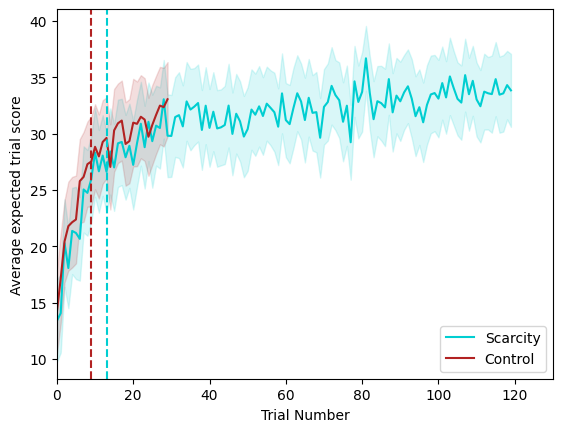

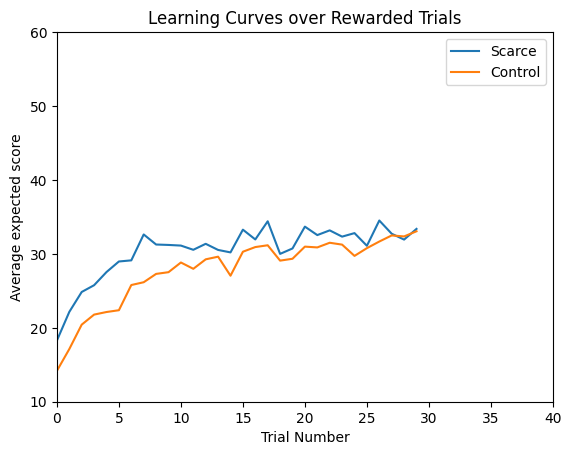

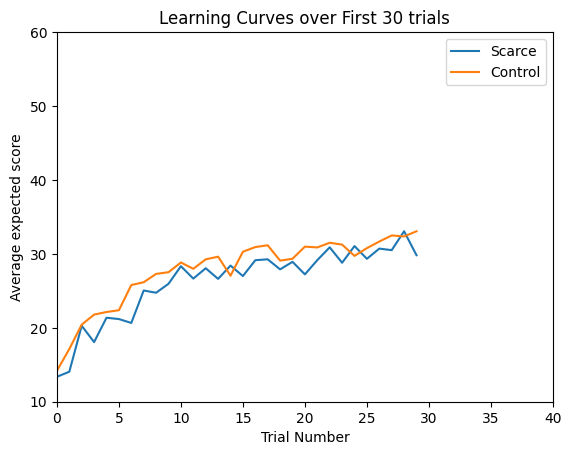

In [424]:
# Plotting mean expected score vs. trial number for each condition

data_to_copy = filtered_data.copy() # all_trials_df, outliers_excluded, or outliers_excluded_part

num_scarce = len(data_to_copy.loc[data_to_copy.scarce == 1].groupby('workerId'))
num_control = len(data_to_copy.loc[data_to_copy.scarce == 0].groupby('workerId'))

# Taking the mean expected score over all trials 
scarce_data_all = np.array(data_to_copy.loc[data_to_copy.scarce == 1].groupby('trialNumbers').mean()["expectedScores"])
scarce_data_all_se = np.array(data_to_copy.loc[data_to_copy.scarce == 1].groupby('trialNumbers').std()["expectedScores"]) / np.sqrt(num_scarce)
control_data = np.array(data_to_copy.loc[data_to_copy.scarce == 0].groupby('trialNumbers').mean()["expectedScores"])
control_data_se = np.array(data_to_copy.loc[data_to_copy.scarce == 0].groupby('trialNumbers').std()["expectedScores"]) / np.sqrt(num_scarce)
scarce_data_first_30 = scarce_data_all[0:30]
scarce_data_first_30_se = scarce_data_all_sd[0:30]

# Taking only the rewarded trials in the scarce condition
rewarded_trials_df = pd.DataFrame(columns=data_to_copy.columns)
for worker in np.unique(data_to_copy.workerId):
    workerRows = data_to_copy.loc[(data_to_copy.scarce == 1) & (data_to_copy.workerId == worker)].reset_index(drop=True)
    rewarded = workerRows.loc[workerRows.rewardsWithheld == False]
    rewarded['trialNumbers'] = list(range(1,len(rewarded)+1))
    rewarded_trials_df = pd.concat([rewarded_trials_df,rewarded], ignore_index=True)

rewarded_trials_df['trialNumbers'] = rewarded_trials_df['trialNumbers'].astype("int64")
rewarded_trials_df['scarce'] = rewarded_trials_df['scarce'].astype("int64")
rewarded_trials_df['numRewardedTrials'] = rewarded_trials_df['numRewardedTrials'].astype("int64")
rewarded_trials_df['numUnrewardedTrials'] = rewarded_trials_df['numUnrewardedTrials'].astype("int64")
rewarded_trials_df['rewardsWithheld'] = rewarded_trials_df['rewardsWithheld'].astype("boolean")
scarce_data_rewarded = np.array(rewarded_trials_df.groupby('trialNumbers').mean()["expectedScores"])
scarce_data_rewarded_sd = np.array(rewarded_trials_df.groupby('trialNumbers').std()["expectedScores"])

plt.figure()
#plt.title("Learning Curves over All Trials")
plt.plot(list(range(len(scarce_data_all))), scarce_data_all, label="Scarcity", color='darkturquoise')
plt.fill_between(list(range(len(scarce_data_all))), scarce_data_all + 1.96*scarce_data_all_se, scarce_data_all - 1.96*scarce_data_all_se, alpha=0.15, color='darkturquoise')
plt.plot(list(range(len(control_data))), control_data, label="Control", color='firebrick')
plt.fill_between(list(range(len(control_data))), control_data + 1.96*control_data_se, control_data - 1.96*control_data_se, alpha=0.15, color='firebrick')
plt.axvline(13, linestyle='--', color='darkturquoise')
plt.axvline(9, linestyle='--', color='firebrick')
#plt.axhline(39.97, color='k', label='Optimal', linestyle="--")
plt.legend(loc="lower right")
#plt.ylim([10,60])
plt.xlim([0, 130])
plt.xlabel("Trial Number")
plt.ylabel("Average expected trial score")
plt.show()

plt.figure()
plt.title("Learning Curves over Rewarded Trials")
plt.plot(list(range(len(scarce_data_rewarded))), scarce_data_rewarded, label="Scarce")
plt.plot(list(range(len(control_data))), control_data, label="Control")
plt.legend()
plt.ylim([10,60])
plt.xlim([0, 40])
plt.xlabel("Trial Number")
plt.ylabel("Average expected score")
plt.show()

plt.figure()
plt.title("Learning Curves over First 30 trials")
plt.plot(list(range(len(scarce_data_first_30))), scarce_data_first_30, label="Scarce")
plt.plot(list(range(len(control_data))), control_data, label="Control")
plt.legend()
plt.ylim([10,60])
plt.xlim([0, 40])
plt.xlabel("Trial Number")
plt.ylabel("Average expected score")
plt.show()



## Clicks

Not reported in publication

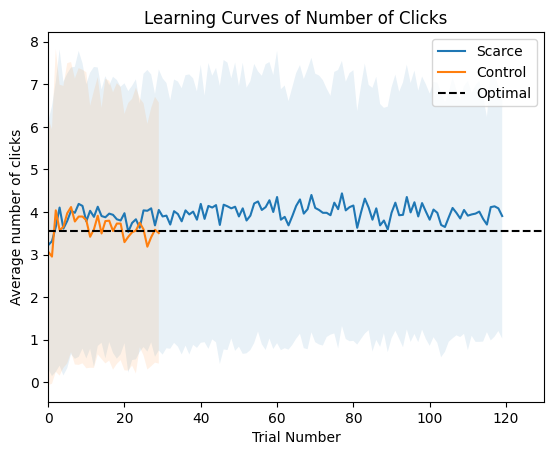

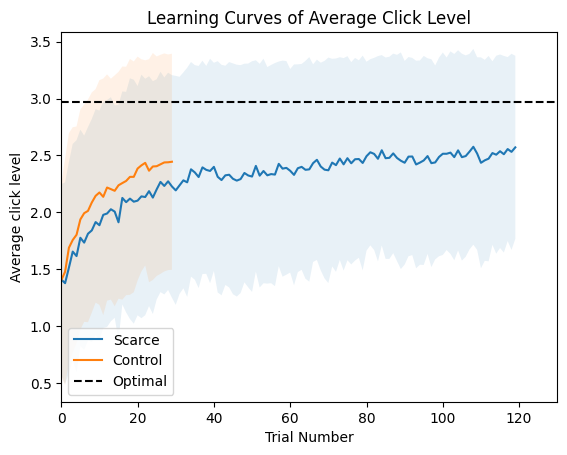

In [326]:
# Plotting mean expected score vs. trial number for each condition

data_to_copy = filtered_data.copy() # all_trials_df, outliers_excluded, or outliers_excluded_part

# Taking the mean expected score over all trials 
scarce_level_all = np.array(data_to_copy.loc[data_to_copy.scarce == 1].groupby('trialNumbers').mean()["avgClickLevel"])
scarce_level_all_sd = np.array(data_to_copy.loc[data_to_copy.scarce == 1].groupby('trialNumbers').std()["avgClickLevel"])
control_level_all = np.array(data_to_copy.loc[data_to_copy.scarce == 0].groupby('trialNumbers').mean()["avgClickLevel"])
control_level_sd = np.array(data_to_copy.loc[data_to_copy.scarce == 0].groupby('trialNumbers').std()["avgClickLevel"])

# Taking the mean expected score over all trials 
scarce_num_all = np.array(data_to_copy.loc[data_to_copy.scarce == 1].groupby('trialNumbers').mean()["numClicks"])
scarce_num_all_sd = np.array(data_to_copy.loc[data_to_copy.scarce == 1].groupby('trialNumbers').std()["numClicks"])
control_num_all = np.array(data_to_copy.loc[data_to_copy.scarce == 0].groupby('trialNumbers').mean()["numClicks"])
control_num_sd = np.array(data_to_copy.loc[data_to_copy.scarce == 0].groupby('trialNumbers').std()["numClicks"])

plt.figure()
plt.title("Learning Curves of Number of Clicks")
plt.plot(list(range(len(scarce_num_all))), scarce_num_all, label="Scarce")
plt.fill_between(list(range(len(scarce_num_all))), scarce_num_all + scarce_num_all_sd, scarce_num_all - scarce_num_all_sd, alpha=0.1)
plt.plot(list(range(len(control_num_all))), control_num_all, label="Control")
plt.fill_between(list(range(len(control_num_all))), control_num_all + control_num_sd, control_num_all - control_num_sd, alpha=0.1)
plt.axhline(3.56, color='k', label='Optimal', linestyle="--")
plt.legend()
plt.xlim([0, 130])
plt.xlabel("Trial Number")
plt.ylabel("Average number of clicks")
plt.show()

plt.figure()
plt.title("Learning Curves of Average Click Level")
plt.plot(list(range(len(scarce_level_all))), scarce_level_all, label="Scarce")
plt.fill_between(list(range(len(scarce_level_all))), scarce_level_all + scarce_level_all_sd, scarce_level_all - scarce_level_all_sd, alpha=0.1)
plt.plot(list(range(len(control_level_all))), control_level_all, label="Control")
plt.fill_between(list(range(len(control_level_all))), control_level_all + control_level_sd, control_level_all - control_level_sd, alpha=0.1)
plt.axhline(2.968, color='k', label='Optimal', linestyle="--")
plt.legend()
plt.xlim([0, 130])
plt.xlabel("Trial Number")
plt.ylabel("Average click level")
plt.show()




## Strategy Scores

Not reported in publication

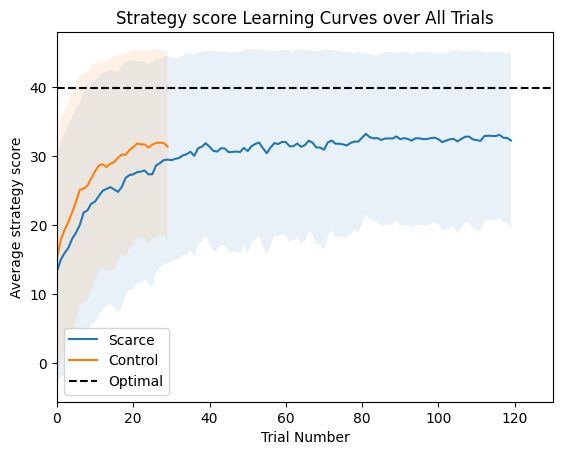

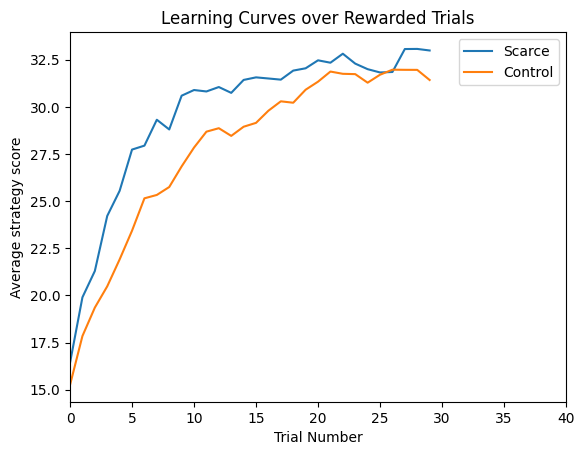

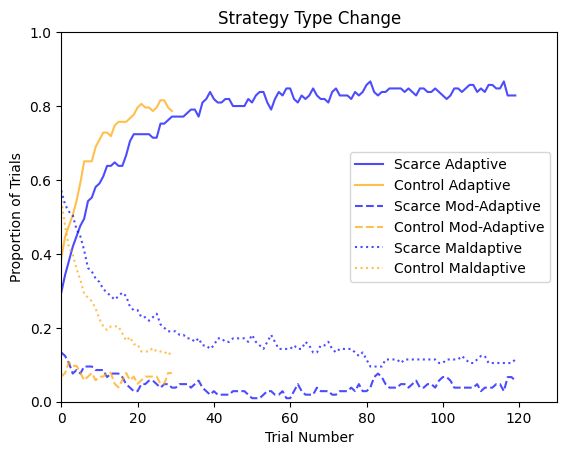

In [327]:
# Plotting mean expected score vs. trial number for each condition

data_to_copy = filtered_data.copy() # all_trials_df, outliers_excluded, or outliers_excluded_part

scarce_trial_group = data_to_copy.loc[data_to_copy.scarce == 1].groupby('trialNumbers')
control_trial_group = data_to_copy.loc[data_to_copy.scarce == 0].groupby('trialNumbers')

# Taking the mean expected score over all trials 
scarce_data_all = np.array(scarce_trial_group.mean()["strategyScores"])
scarce_data_all_sd = np.array(scarce_trial_group.std()["strategyScores"])
control_data = np.array(control_trial_group.mean()["strategyScores"])
control_data_sd = np.array(control_trial_group.std()["strategyScores"])

# Getting the proportions of clusters
scarce_data_adaptive = np.array(scarce_trial_group["cluster"].apply(lambda x: (x==0).sum()) / scarce_trial_group["cluster"].count())
control_data_adaptive = np.array(control_trial_group["cluster"].apply(lambda x: (x==0).sum()) / control_trial_group["cluster"].count())
scarce_data_modadaptive = np.array(scarce_trial_group["cluster"].apply(lambda x: (x==1).sum()) / scarce_trial_group["cluster"].count())
control_data_modadaptive = np.array(control_trial_group["cluster"].apply(lambda x: (x==1).sum()) / control_trial_group["cluster"].count())
scarce_data_maladaptive = np.array(scarce_trial_group["cluster"].apply(lambda x: (x==2).sum()) / scarce_trial_group["cluster"].count())
control_data_maladaptive = np.array(control_trial_group["cluster"].apply(lambda x: (x==2).sum()) / control_trial_group["cluster"].count())
#control_data = np.array(data_to_copy.loc[data_to_copy.scarce == 0].groupby('trialNumbers').mean()["strategyScores"])
#control_data_sd = np.array(data_to_copy.loc[data_to_copy.scarce == 0].groupby('trialNumbers').std()["strategyScores"])

# Taking only the rewarded trials in the scarce condition
rewarded_trials_df = pd.DataFrame(columns=data_to_copy.columns)
for worker in np.unique(data_to_copy.workerId):
    workerRows = data_to_copy.loc[(data_to_copy.scarce == 1) & (data_to_copy.workerId == worker)].reset_index(drop=True)
    rewarded = workerRows.loc[workerRows.rewardsWithheld == False]
    rewarded['trialNumbers'] = list(range(1,len(rewarded)+1))
    rewarded_trials_df = pd.concat([rewarded_trials_df,rewarded], ignore_index=True)

rewarded_trials_df['trialNumbers'] = rewarded_trials_df['trialNumbers'].astype("int64")
rewarded_trials_df['scarce'] = rewarded_trials_df['scarce'].astype("int64")
rewarded_trials_df['numRewardedTrials'] = rewarded_trials_df['numRewardedTrials'].astype("int64")
rewarded_trials_df['numUnrewardedTrials'] = rewarded_trials_df['numUnrewardedTrials'].astype("int64")
rewarded_trials_df['rewardsWithheld'] = rewarded_trials_df['rewardsWithheld'].astype("boolean")
scarce_data_rewarded = np.array(rewarded_trials_df.groupby('trialNumbers').mean()["strategyScores"])
scarce_data_rewarded_sd = np.array(rewarded_trials_df.groupby('trialNumbers').std()["strategyScores"])

plt.figure()
plt.title("Strategy score Learning Curves over All Trials")
plt.plot(list(range(len(scarce_data_all))), scarce_data_all, label="Scarce")
plt.fill_between(list(range(len(scarce_data_all))), scarce_data_all + scarce_data_all_sd, scarce_data_all - scarce_data_all_sd, alpha=0.1)
plt.plot(list(range(len(control_data))), control_data, label="Control")
plt.fill_between(list(range(len(control_data))), control_data + control_data_sd, control_data - control_data_sd, alpha=0.1)
plt.axhline(np.max(np.array(strategy_scores_control_list)[:,1], axis=0), color='k', label='Optimal', linestyle="--")
plt.legend()
plt.xlim([0, 130])
plt.xlabel("Trial Number")
plt.ylabel("Average strategy score")
plt.show()

plt.figure()
plt.title("Learning Curves over Rewarded Trials")
plt.plot(list(range(len(scarce_data_rewarded))), scarce_data_rewarded, label="Scarce")
plt.plot(list(range(len(control_data))), control_data, label="Control")
plt.legend()
plt.xlim([0, 40])
plt.xlabel("Trial Number")
plt.ylabel("Average strategy score")
plt.show()

plt.figure()
plt.title("Strategy Type Change")
alpha = 0.7
plt.plot(list(range(len(scarce_data_all))), scarce_data_adaptive, label="Scarce Adaptive", color='b',alpha=alpha)
plt.plot(list(range(len(control_data))), control_data_adaptive, label="Control Adaptive",color='orange',alpha=alpha)
plt.plot(list(range(len(scarce_data_all))), scarce_data_modadaptive, label="Scarce Mod-Adaptive", color='b',alpha=alpha, linestyle="--")
plt.plot(list(range(len(control_data))), control_data_modadaptive, label="Control Mod-Adaptive",color='orange',alpha=alpha, linestyle="--")
plt.plot(list(range(len(scarce_data_all))), scarce_data_maladaptive, label="Scarce Maldaptive", color='b',alpha=alpha, linestyle=":")
plt.plot(list(range(len(control_data))), control_data_maladaptive, label="Control Maldaptive",color='orange',alpha=alpha, linestyle=":")
plt.legend()
plt.ylim([0,1])
plt.xlim([0, 130])
plt.xlabel("Trial Number")
plt.ylabel("Proportion of Trials")
plt.show()


# 0.1 - Transforming Response Data

Not used for results reported in paper

In [328]:
def scale_to_range(arr, lb, ub):
    return ((arr - arr.min()) / (arr.max() - arr.min())) * (ub - lb) + lb

In [329]:
# Selecting the response variable

response_vars = ['expectedScores', 'avgClickLevel', 'strategyScores']

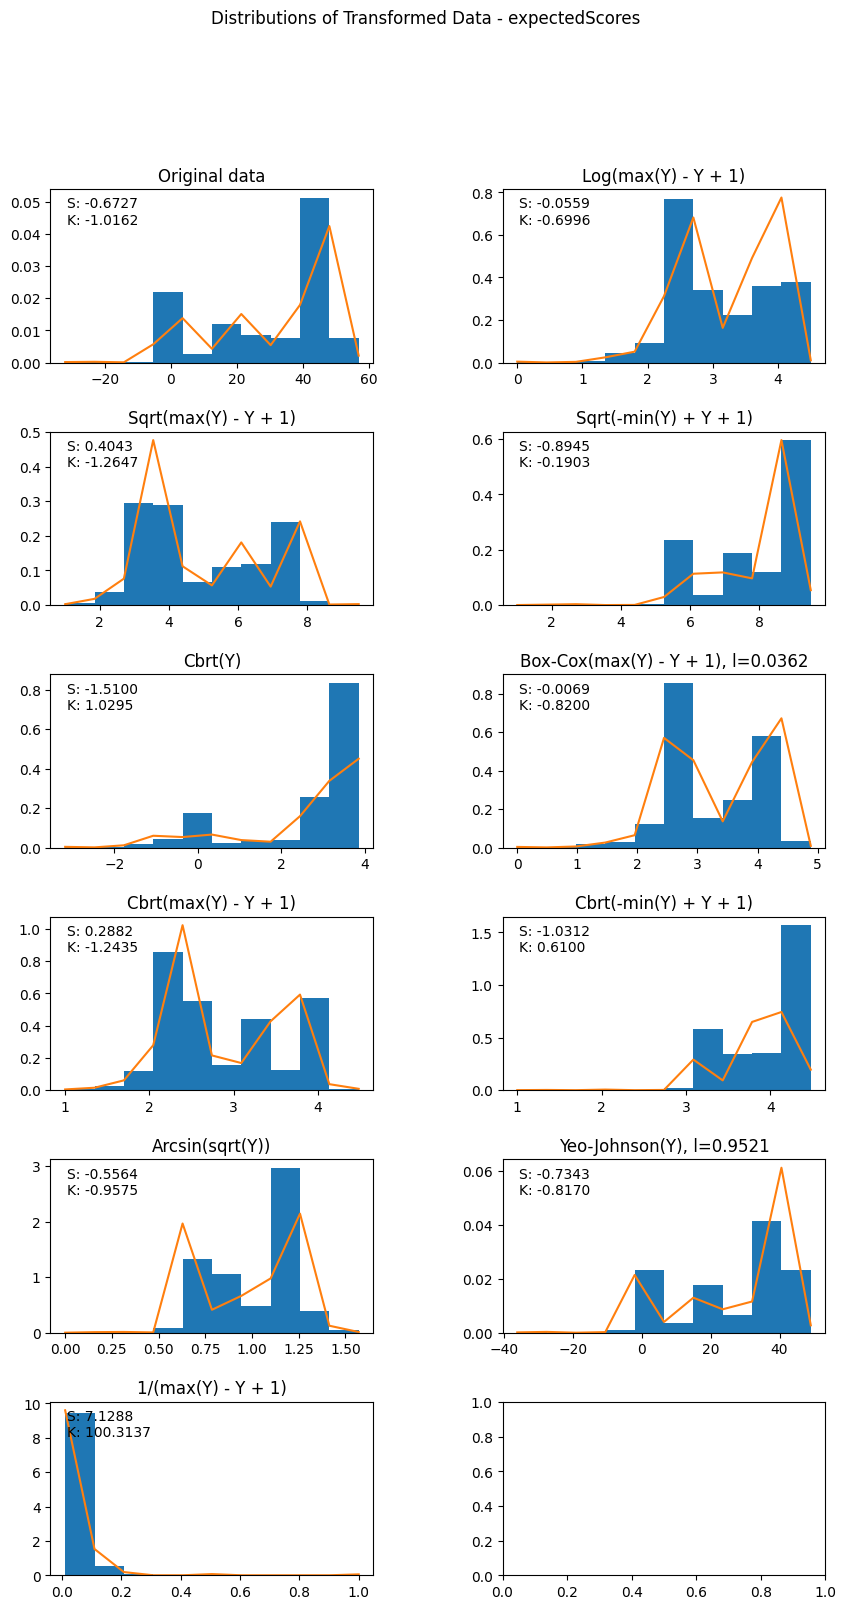

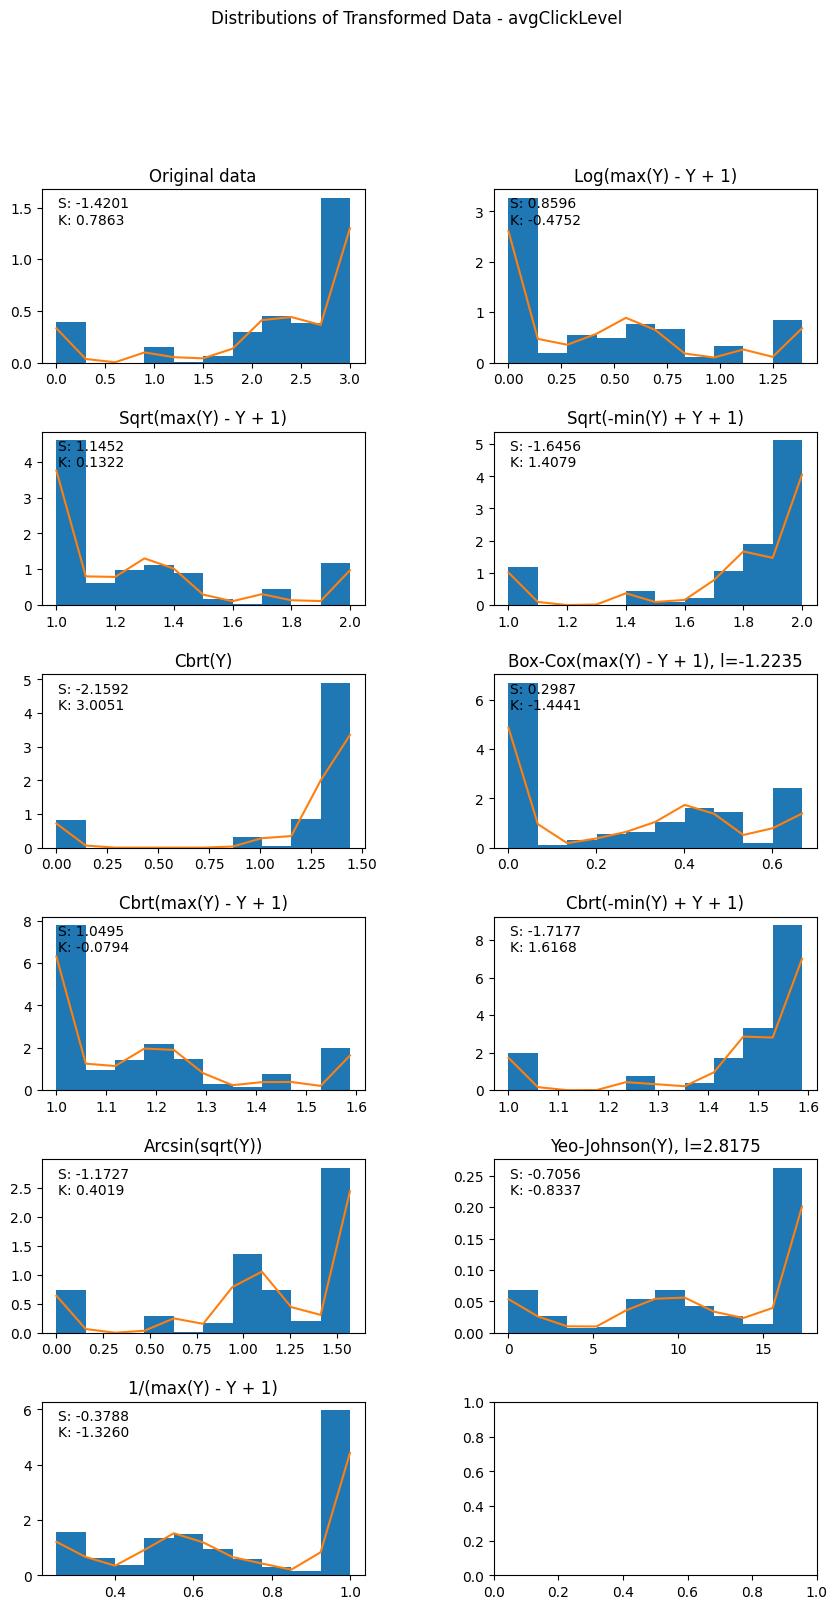

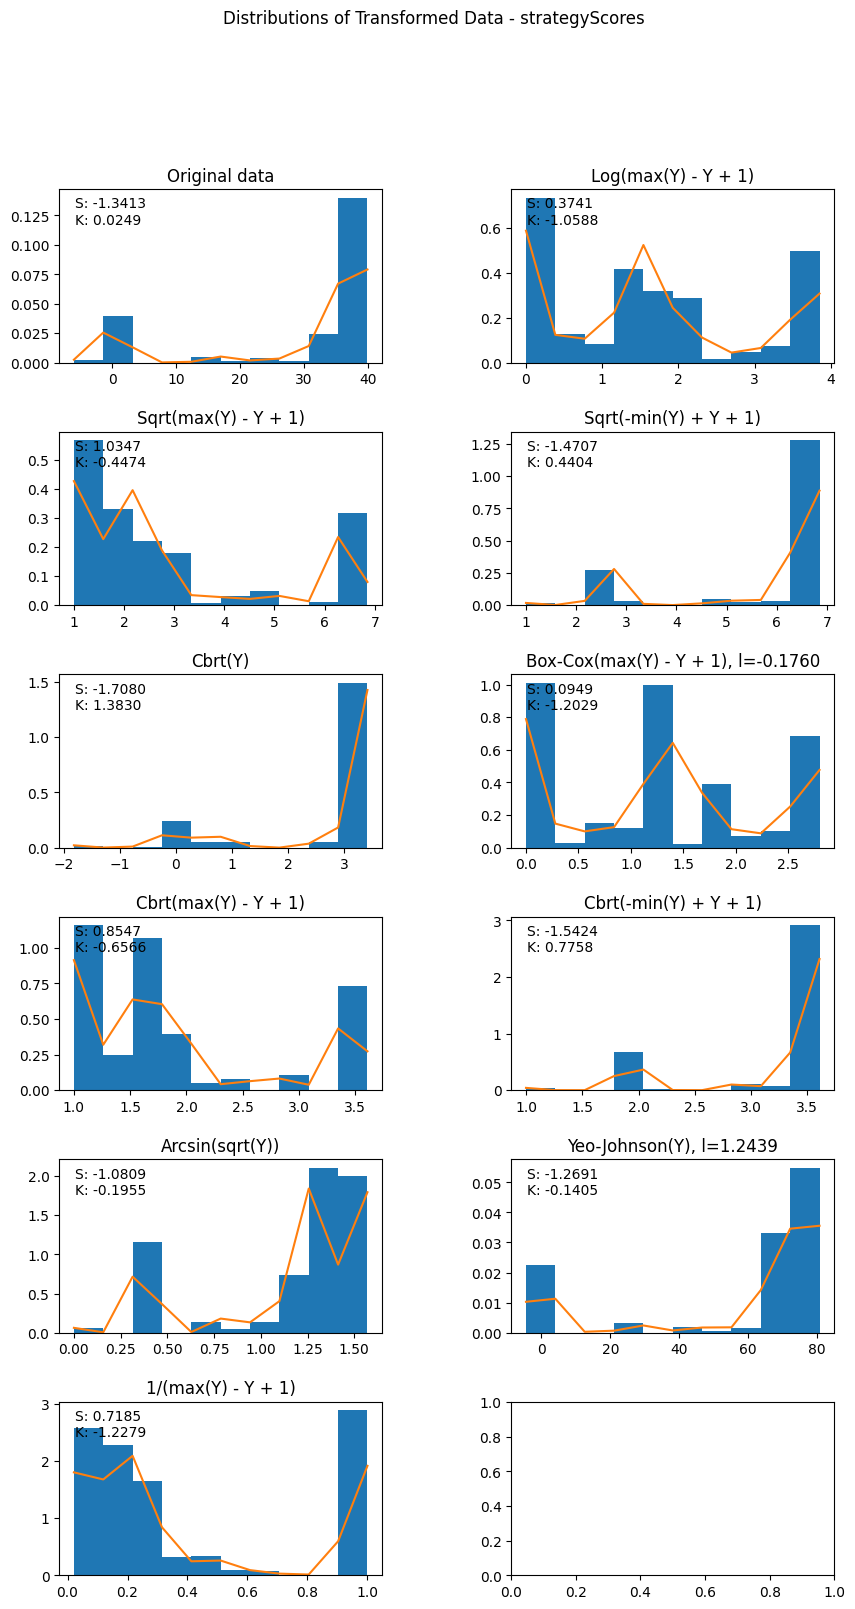

In [330]:
# Transforming the data

data_to_copy = filtered_data.copy() # or outliers_excluded
transformed_trials_df = data_to_copy.copy()
trans_list = {res: [] for res in response_vars}

for response_var in response_vars:
    

    log_transformed_trials_df = data_to_copy.copy()
    sq_transformed_trials_df = data_to_copy.copy()
    sq2_transformed_trials_df = data_to_copy.copy()
    cb_transformed_trials_df = data_to_copy.copy()
    cb2_transformed_trials_df = data_to_copy.copy()
    cb3_transformed_trials_df = data_to_copy.copy()
    arcsin_transformed_trials_df = data_to_copy.copy()
    bc_transformed_trials_df = data_to_copy.copy()
    yj_transformed_trials_df = data_to_copy.copy()
    inverse_transformed_trials_df = data_to_copy.copy()

    # Compute separate dataframes for each transformation
    log_transformed_trials_df[response_var] = np.log(transformed_trials_df[response_var].max() + 1 - transformed_trials_df[response_var])
    sq_transformed_trials_df[response_var] = np.sqrt(transformed_trials_df[response_var].max() + 1 - transformed_trials_df[response_var])
    sq2_transformed_trials_df[response_var] = np.sqrt(-transformed_trials_df[response_var].min() + 1 + transformed_trials_df[response_var])
    cb_transformed_trials_df[response_var] = np.cbrt(transformed_trials_df[response_var])
    cb2_transformed_trials_df[response_var] = np.cbrt(transformed_trials_df[response_var].max() + 1 - transformed_trials_df[response_var])
    cb3_transformed_trials_df[response_var] = np.cbrt(-transformed_trials_df[response_var].min() + 1 + transformed_trials_df[response_var])
    arcsin_transformed_trials_df[response_var] = np.arcsin(np.sqrt(scale_to_range(transformed_trials_df[response_var], 0, 1)))
    bc_transformed_trials_df[response_var],lam = scipy.stats.boxcox(transformed_trials_df[response_var].max() + 1 - transformed_trials_df[response_var])
    #logit_transformed_trials_df[response_var] = scipy.special.logit(scale_to_range(transformed_trials_df[response_var], 0, 1))
    yj_transformed_trials_df[response_var],lam_y = scipy.stats.yeojohnson(transformed_trials_df[response_var])
    inverse_transformed_trials_df[response_var] = 1/(transformed_trials_df[response_var].max() + 1 - transformed_trials_df[response_var])

    # All the transformed data and the corresponding transformation
    trans_list[response_var] = [
        (transformed_trials_df, "Original data"),
        (log_transformed_trials_df, "Log(max(Y) - Y + 1)"),
        (sq_transformed_trials_df, "Sqrt(max(Y) - Y + 1)"),
        (sq2_transformed_trials_df, "Sqrt(-min(Y) + Y + 1)"),
        (cb_transformed_trials_df, "Cbrt(Y)"),
        (bc_transformed_trials_df, "Box-Cox(max(Y) - Y + 1), l={0:0.4f}".format(lam)),
        (cb2_transformed_trials_df, "Cbrt(max(Y) - Y + 1)"),
        (cb3_transformed_trials_df, "Cbrt(-min(Y) + Y + 1)"),
        (arcsin_transformed_trials_df, "Arcsin(sqrt(Y))"),
        (yj_transformed_trials_df, "Yeo-Johnson(Y), l={0:0.4f}".format(lam_y)),
        (inverse_transformed_trials_df, "1/(max(Y) - Y + 1)")
    ]
    
    # Plot all the transformed data
    fig, ax = plt.subplots(nrows=math.ceil(len(trans_list[response_var])/2),ncols=2,figsize=(10, 3 * math.ceil(len(trans_list[response_var])/2)),squeeze=False)
    plt.suptitle("Distributions of Transformed Data - {}".format(response_var))
    ax = ax.flatten()

    for idx, trans in enumerate(trans_list[response_var]):
        data = trans[0][response_var]
        label = trans[1]
        skew = scipy.stats.skew(data)
        density = scipy.stats.gaussian_kde(data)
        kurtosis = scipy.stats.kurtosis(data)
        n, x, _ = ax[idx].hist(data, density=True)
        ax[idx].set_title(label)
        ax[idx].plot(x, density(x))
        ax[idx].text(0.05,0.8, "S: {0:0.4f}\nK: {1:0.4f}".format(skew, kurtosis), transform=ax[idx].transAxes)

    plt.subplots_adjust(
                    wspace=0.4, 
                    hspace=0.4)
plt.show()

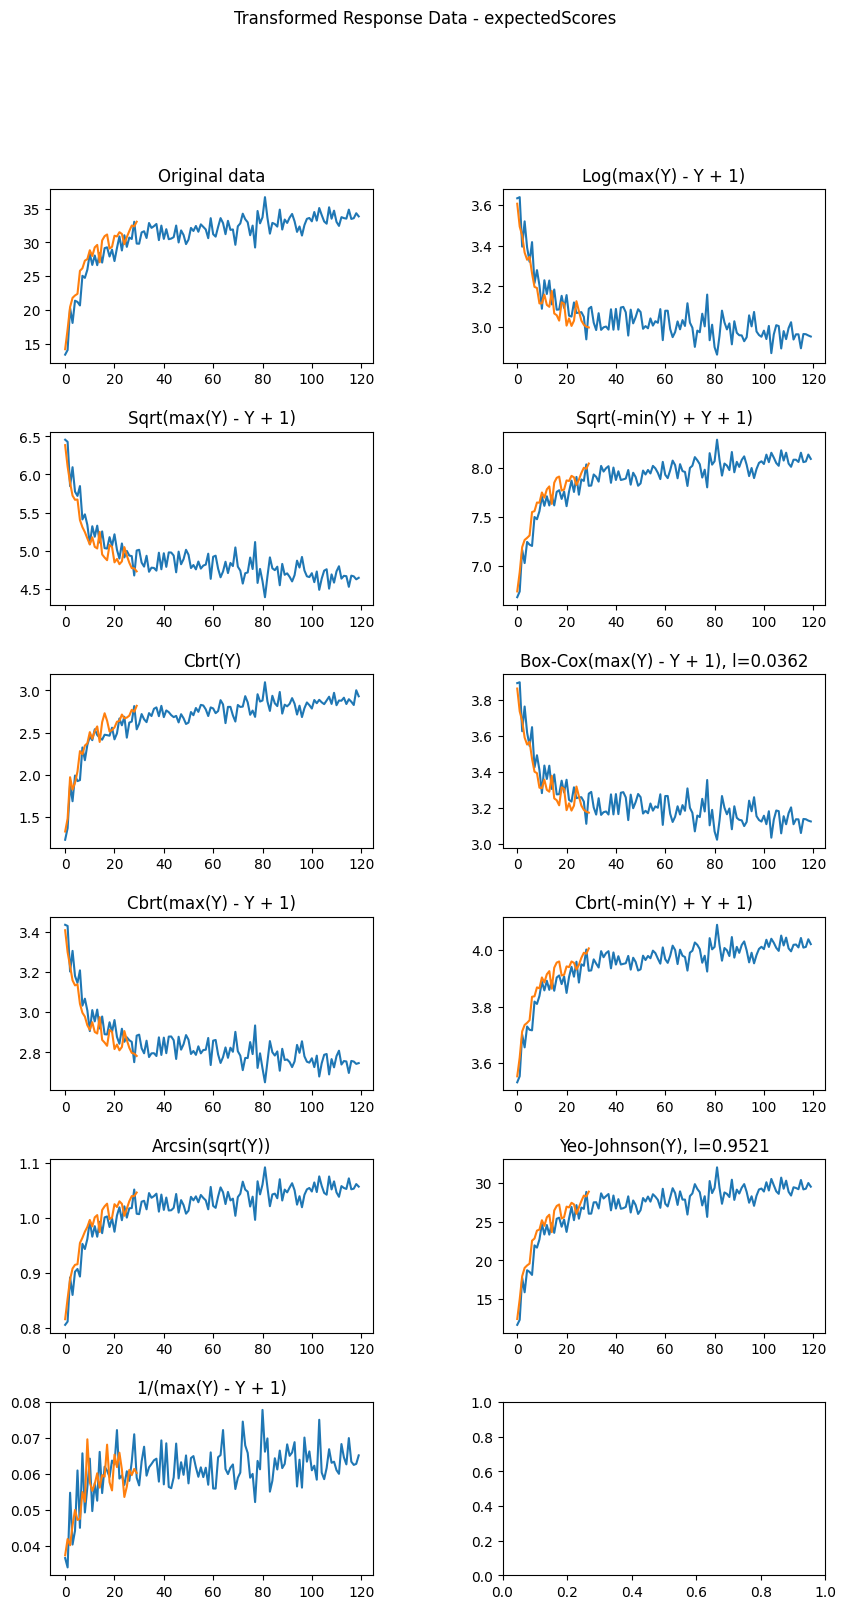

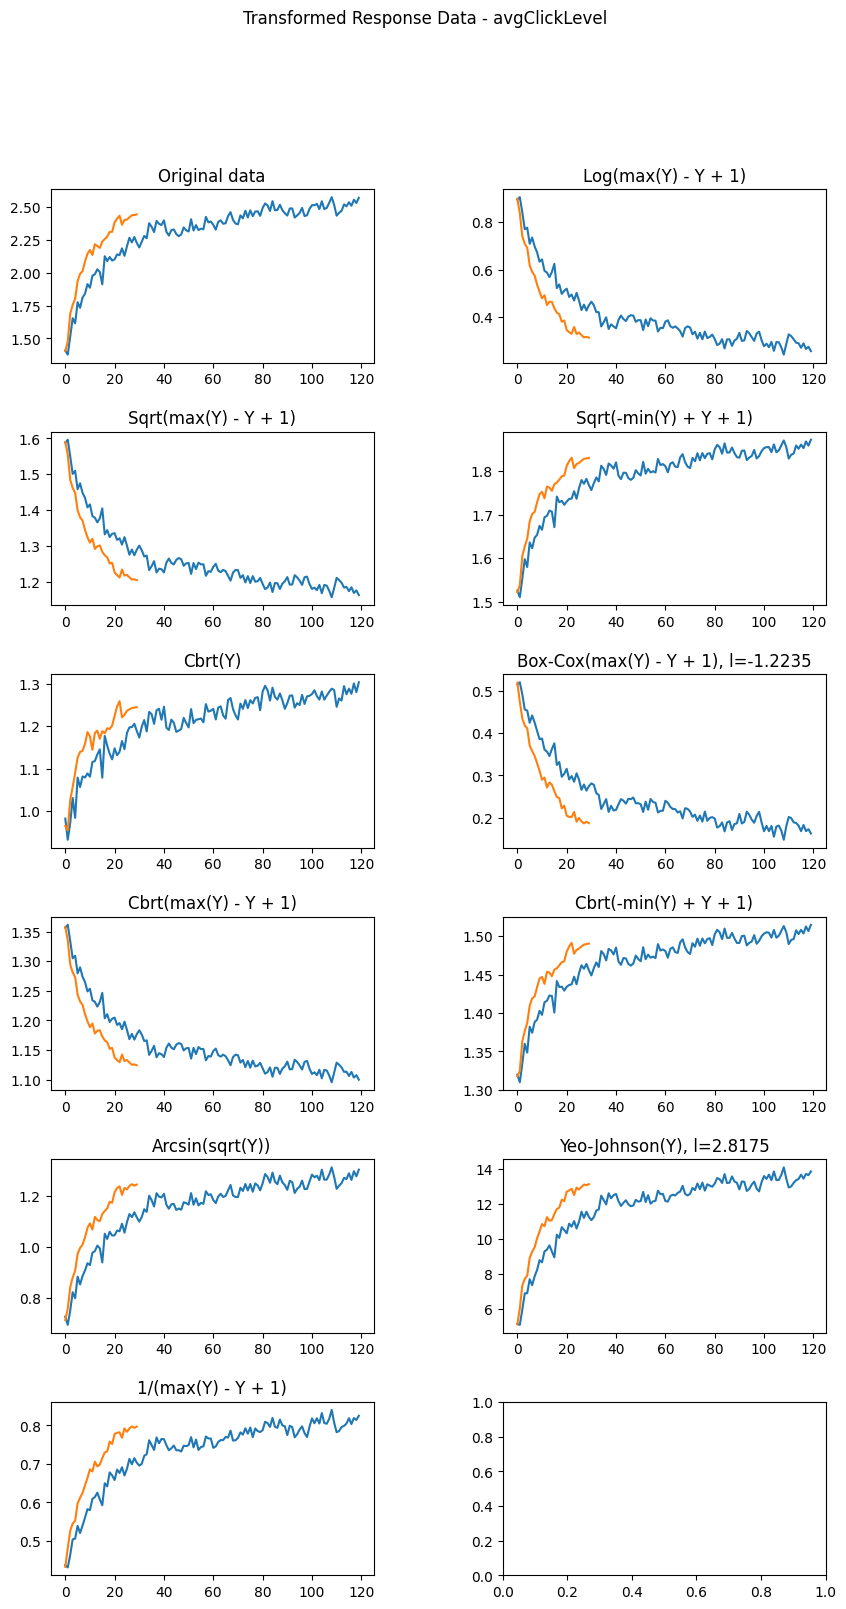

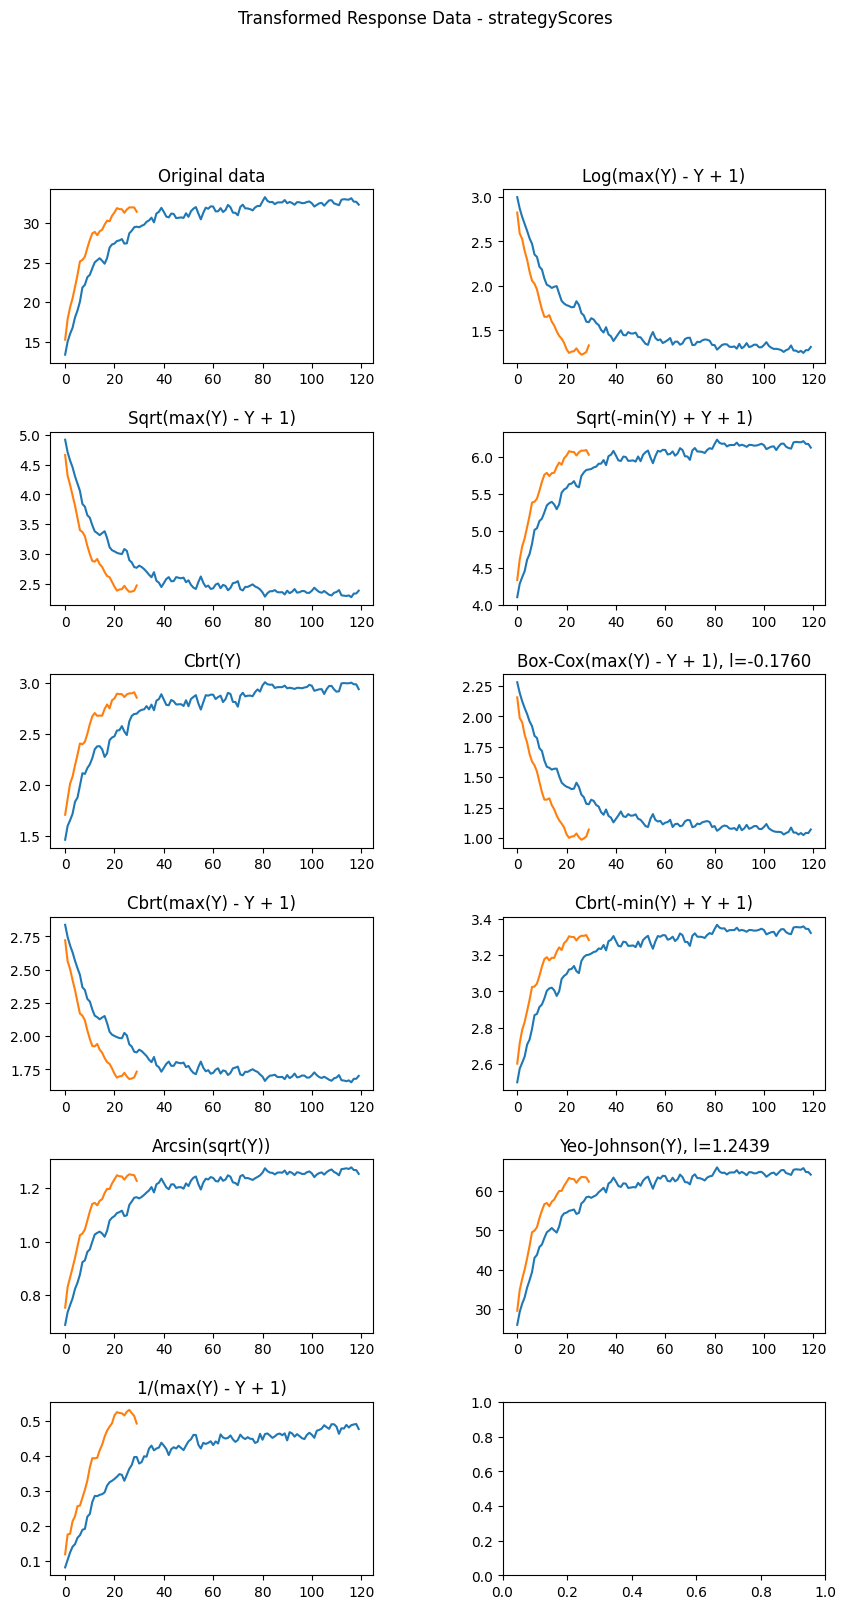

In [331]:
# Plotting the response data

for response_var in response_vars:
    fig, ax = plt.subplots(nrows=math.ceil(len(trans_list[response_var])/2),ncols=2,figsize=(10, 3 * math.ceil(len(trans_list[response_var])/2)),squeeze=False)
    plt.suptitle("Transformed Response Data - {}".format(response_var))
    ax = ax.flatten()

    for idx, trans in enumerate(trans_list[response_var]):
        data = trans[0]
        scarce = data.loc[data.scarce == 1]
        control = data.loc[data.scarce == 0]
        label = trans[1]

        scarce_mean = np.array(scarce.groupby('trialNumbers').mean()[response_var])
        control_mean = np.array(control.groupby('trialNumbers').mean()[response_var])
        ax[idx].plot(list(range(len(scarce_mean))), scarce_mean, label="Scarce")
        ax[idx].plot(list(range(len(control_mean))), control_mean, label="Control")
        ax[idx].set_title(label)

    plt.subplots_adjust(
                    wspace=0.4, 
                    hspace=0.4)
plt.show()

## Linear Regression: Expected Score vs. Trial Number x Condition

In [332]:
# formula = "expectedScores ~ trialNumbers + C(scarce) + trialNumbers:C(scarce)"

In [333]:
# GLM Model 1 - Expected score vs. Trial number & Condition - all possible transformations

# Creating the list of data to subplot all residuals

all_residuals = {res: [] for res in response_vars}
mixed = True

for response_var in response_vars:
    formula = '{} ~ C(trialNumbers) + C(scarce)'.format(response_var);

    # Perform regression on each transformed dataset
    for idx, trans in enumerate(trans_list[response_var]):
        if mixed:
            glm = smf.mixedlm(formula=formula, data=trans[0], groups=trans[0]['workerId'])
        else:
            glm = smf.glm(formula=formula, data=trans[0])

        results = glm.fit()

        print("\n{} - {}:".format(response_var, trans[1]))
        print(results.summary())

        resids = results.resid_response if not mixed else results.resid
        normaltest = scipy.stats.normaltest(resids)
        
        # Save the results of the regression for plotting
        all_residuals[response_var].append((
            resids,
            trans[0][response_var],
            trans[1],
            normaltest
        ))



expectedScores - Original data:
              Mixed Linear Model Regression Results
Model:              MixedLM   Dependent Variable:   expectedScores
No. Observations:   15690     Method:               REML          
No. Groups:         208       Scale:                195.1220      
Min. group size:    30        Log-Likelihood:       -63838.7498   
Max. group size:    120       Converged:            Yes           
Mean group size:    75.4                                          
------------------------------------------------------------------
                        Coef.  Std.Err.   z    P>|z| [0.025 0.975]
------------------------------------------------------------------
Intercept               14.568    1.574  9.253 0.000 11.482 17.654
C(trialNumbers)[T.2]     1.808    1.370  1.320 0.187 -0.877  4.492
C(trialNumbers)[T.3]     6.582    1.370  4.805 0.000  3.897  9.266
C(trialNumbers)[T.4]     6.139    1.370  4.482 0.000  3.455  8.824
C(trialNumbers)[T.5]     7.976    1.370  5.8


expectedScores - Log(max(Y) - Y + 1):
              Mixed Linear Model Regression Results
Model:              MixedLM   Dependent Variable:   expectedScores
No. Observations:   15690     Method:               REML          
No. Groups:         208       Scale:                0.3442        
Min. group size:    30        Log-Likelihood:       -14435.5354   
Max. group size:    120       Converged:            Yes           
Mean group size:    75.4                                          
------------------------------------------------------------------
                       Coef.  Std.Err.    z    P>|z| [0.025 0.975]
------------------------------------------------------------------
Intercept               3.596    0.058  62.073 0.000  3.482  3.710
C(trialNumbers)[T.2]   -0.053    0.058  -0.918 0.359 -0.166  0.060
C(trialNumbers)[T.3]   -0.197    0.058  -3.429 0.001 -0.310 -0.085
C(trialNumbers)[T.4]   -0.176    0.058  -3.060 0.002 -0.289 -0.063
C(trialNumbers)[T.5]   -0.258    0.058


expectedScores - Sqrt(max(Y) - Y + 1):
              Mixed Linear Model Regression Results
Model:              MixedLM   Dependent Variable:   expectedScores
No. Observations:   15690     Method:               REML          
No. Groups:         208       Scale:                1.8466        
Min. group size:    30        Log-Likelihood:       -27541.3690   
Max. group size:    120       Converged:            Yes           
Mean group size:    75.4                                          
------------------------------------------------------------------
                       Coef.  Std.Err.    z    P>|z| [0.025 0.975]
------------------------------------------------------------------
Intercept               6.352    0.145  43.896 0.000  6.068  6.635
C(trialNumbers)[T.2]   -0.154    0.133  -1.153 0.249 -0.415  0.107
C(trialNumbers)[T.3]   -0.553    0.133  -4.149 0.000 -0.814 -0.292
C(trialNumbers)[T.4]   -0.511    0.133  -3.833 0.000 -0.772 -0.250
C(trialNumbers)[T.5]   -0.700    0.13


expectedScores - Sqrt(-min(Y) + Y + 1):
              Mixed Linear Model Regression Results
Model:               MixedLM  Dependent Variable:  expectedScores
No. Observations:    15690    Method:              REML          
No. Groups:          208      Scale:               0.9016        
Min. group size:     30       Log-Likelihood:      -21983.8724   
Max. group size:     120      Converged:           Yes           
Mean group size:     75.4                                        
-----------------------------------------------------------------
                       Coef.  Std.Err.   z    P>|z| [0.025 0.975]
-----------------------------------------------------------------
Intercept               6.765    0.108 62.515 0.000  6.553  6.977
C(trialNumbers)[T.2]    0.127    0.093  1.359 0.174 -0.056  0.309
C(trialNumbers)[T.3]    0.468    0.093  5.030 0.000  0.286  0.651
C(trialNumbers)[T.4]    0.436    0.093  4.685 0.000  0.254  0.619
C(trialNumbers)[T.5]    0.556    0.093  5.970 0.0


expectedScores - Cbrt(Y):
              Mixed Linear Model Regression Results
Model:               MixedLM  Dependent Variable:  expectedScores
No. Observations:    15690    Method:              REML          
No. Groups:          208      Scale:               0.9879        
Min. group size:     30       Log-Likelihood:      -22730.9557   
Max. group size:     120      Converged:           Yes           
Mean group size:     75.4                                        
-----------------------------------------------------------------
                       Coef.  Std.Err.   z    P>|z| [0.025 0.975]
-----------------------------------------------------------------
Intercept               1.324    0.127 10.401 0.000  1.074  1.573
C(trialNumbers)[T.2]    0.145    0.097  1.491 0.136 -0.046  0.336
C(trialNumbers)[T.3]    0.651    0.097  6.680 0.000  0.460  0.842
C(trialNumbers)[T.4]    0.476    0.097  4.885 0.000  0.285  0.667
C(trialNumbers)[T.5]    0.670    0.097  6.874 0.000  0.479  0.8


expectedScores - Box-Cox(max(Y) - Y + 1), l=0.0362:
              Mixed Linear Model Regression Results
Model:              MixedLM   Dependent Variable:   expectedScores
No. Observations:   15690     Method:               REML          
No. Groups:         208       Scale:                0.4259        
Min. group size:    30        Log-Likelihood:       -16095.9961   
Max. group size:    120       Converged:            Yes           
Mean group size:    75.4                                          
------------------------------------------------------------------
                       Coef.  Std.Err.    z    P>|z| [0.025 0.975]
------------------------------------------------------------------
Intercept               3.850    0.065  59.374 0.000  3.723  3.977
C(trialNumbers)[T.2]   -0.060    0.064  -0.938 0.348 -0.185  0.065
C(trialNumbers)[T.3]   -0.223    0.064  -3.482 0.000 -0.348 -0.097
C(trialNumbers)[T.4]   -0.200    0.064  -3.120 0.002 -0.325 -0.074
C(trialNumbers)[T.5]   -


expectedScores - Cbrt(max(Y) - Y + 1):
              Mixed Linear Model Regression Results
Model:              MixedLM   Dependent Variable:   expectedScores
No. Observations:   15690     Method:               REML          
No. Groups:         208       Scale:                0.2875        
Min. group size:    30        Log-Likelihood:       -13055.8491   
Max. group size:    120       Converged:            Yes           
Mean group size:    75.4                                          
------------------------------------------------------------------
                       Coef.  Std.Err.    z    P>|z| [0.025 0.975]
------------------------------------------------------------------
Intercept               3.395    0.056  60.832 0.000  3.286  3.504
C(trialNumbers)[T.2]   -0.057    0.053  -1.084 0.278 -0.160  0.046
C(trialNumbers)[T.3]   -0.206    0.053  -3.913 0.000 -0.309 -0.103
C(trialNumbers)[T.4]   -0.189    0.053  -3.589 0.000 -0.292 -0.086
C(trialNumbers)[T.5]   -0.264    0.05


expectedScores - Cbrt(-min(Y) + Y + 1):
              Mixed Linear Model Regression Results
Model:               MixedLM  Dependent Variable:  expectedScores
No. Observations:    15690    Method:              REML          
No. Groups:          208      Scale:               0.1090        
Min. group size:     30       Log-Likelihood:      -5532.0358    
Max. group size:     120      Converged:           Yes           
Mean group size:     75.4                                        
-----------------------------------------------------------------
                       Coef.  Std.Err.   z    P>|z| [0.025 0.975]
-----------------------------------------------------------------
Intercept               3.562    0.038 94.978 0.000  3.489  3.636
C(trialNumbers)[T.2]    0.044    0.032  1.357 0.175 -0.020  0.107
C(trialNumbers)[T.3]    0.164    0.032  5.053 0.000  0.100  0.227
C(trialNumbers)[T.4]    0.152    0.032  4.703 0.000  0.089  0.216
C(trialNumbers)[T.5]    0.193    0.032  5.959 0.0


expectedScores - Arcsin(sqrt(Y)):
              Mixed Linear Model Regression Results
Model:               MixedLM  Dependent Variable:  expectedScores
No. Observations:    15690    Method:              REML          
No. Groups:          208      Scale:               0.0330        
Min. group size:     30       Log-Likelihood:      3778.6876     
Max. group size:     120      Converged:           Yes           
Mean group size:     75.4                                        
-----------------------------------------------------------------
                       Coef.  Std.Err.   z    P>|z| [0.025 0.975]
-----------------------------------------------------------------
Intercept               0.820    0.020 41.525 0.000  0.782  0.859
C(trialNumbers)[T.2]    0.022    0.018  1.211 0.226 -0.013  0.056
C(trialNumbers)[T.3]    0.079    0.018  4.448 0.000  0.044  0.114
C(trialNumbers)[T.4]    0.073    0.018  4.095 0.000  0.038  0.108
C(trialNumbers)[T.5]    0.098    0.018  5.477 0.000  0.


expectedScores - Yeo-Johnson(Y), l=0.9521:
              Mixed Linear Model Regression Results
Model:              MixedLM   Dependent Variable:   expectedScores
No. Observations:   15690     Method:               REML          
No. Groups:         208       Scale:                147.4233      
Min. group size:    30        Log-Likelihood:       -61657.4528   
Max. group size:    120       Converged:            Yes           
Mean group size:    75.4                                          
------------------------------------------------------------------
                        Coef.  Std.Err.   z    P>|z| [0.025 0.975]
------------------------------------------------------------------
Intercept               12.729    1.372  9.278 0.000 10.040 15.418
C(trialNumbers)[T.2]     1.588    1.191  1.334 0.182 -0.745  3.922
C(trialNumbers)[T.3]     5.809    1.191  4.879 0.000  3.476  8.143
C(trialNumbers)[T.4]     5.403    1.191  4.538 0.000  3.070  7.737
C(trialNumbers)[T.5]     6.999   


expectedScores - 1/(max(Y) - Y + 1):
             Mixed Linear Model Regression Results
Model:             MixedLM  Dependent Variable:  expectedScores
No. Observations:  15690    Method:              REML          
No. Groups:        208      Scale:               0.0026        
Min. group size:   30       Log-Likelihood:      23598.4259    
Max. group size:   120      Converged:           Yes           
Mean group size:   75.4                                        
---------------------------------------------------------------
                       Coef. Std.Err.   z   P>|z| [0.025 0.975]
---------------------------------------------------------------
Intercept              0.037    0.004 8.980 0.000  0.029  0.045
C(trialNumbers)[T.2]   0.001    0.005 0.188 0.851 -0.009  0.011
C(trialNumbers)[T.3]   0.011    0.005 2.103 0.035  0.001  0.020
C(trialNumbers)[T.4]   0.006    0.005 1.200 0.230 -0.004  0.016
C(trialNumbers)[T.5]   0.010    0.005 2.009 0.045  0.000  0.020
C(trialNumbers)


avgClickLevel - Original data:
              Mixed Linear Model Regression Results
Model:              MixedLM   Dependent Variable:   avgClickLevel
No. Observations:   15690     Method:               REML         
No. Groups:         208       Scale:                0.2731       
Min. group size:    30        Log-Likelihood:       -12791.1968  
Max. group size:    120       Converged:            Yes          
Mean group size:    75.4                                         
-----------------------------------------------------------------
                       Coef.  Std.Err.   z    P>|z| [0.025 0.975]
-----------------------------------------------------------------
Intercept               1.508    0.087 17.349 0.000  1.337  1.678
C(trialNumbers)[T.2]    0.020    0.051  0.390 0.697 -0.080  0.120
C(trialNumbers)[T.3]    0.193    0.051  3.776 0.000  0.093  0.294
C(trialNumbers)[T.4]    0.298    0.051  5.824 0.000  0.198  0.399
C(trialNumbers)[T.5]    0.301    0.051  5.879 0.000  0.201


avgClickLevel - Log(max(Y) - Y + 1):
              Mixed Linear Model Regression Results
Model:               MixedLM   Dependent Variable:   avgClickLevel
No. Observations:    15690     Method:               REML         
No. Groups:          208       Scale:                0.0709       
Min. group size:     30        Log-Likelihood:       -2279.1244   
Max. group size:     120       Converged:            Yes          
Mean group size:     75.4                                         
------------------------------------------------------------------
                       Coef.  Std.Err.    z    P>|z| [0.025 0.975]
------------------------------------------------------------------
Intercept               0.836    0.041  20.186 0.000  0.755  0.917
C(trialNumbers)[T.2]   -0.025    0.026  -0.965 0.335 -0.076  0.026
C(trialNumbers)[T.3]   -0.105    0.026  -4.015 0.000 -0.156 -0.054
C(trialNumbers)[T.4]   -0.157    0.026  -5.995 0.000 -0.208 -0.105
C(trialNumbers)[T.5]   -0.162    0.026 


avgClickLevel - Sqrt(max(Y) - Y + 1):
              Mixed Linear Model Regression Results
Model:               MixedLM   Dependent Variable:   avgClickLevel
No. Observations:    15690     Method:               REML         
No. Groups:          208       Scale:                0.0330       
Min. group size:     30        Log-Likelihood:       3670.0328    
Max. group size:     120       Converged:            Yes          
Mean group size:     75.4                                         
------------------------------------------------------------------
                       Coef.  Std.Err.    z    P>|z| [0.025 0.975]
------------------------------------------------------------------
Intercept               1.550    0.029  52.930 0.000  1.493  1.607
C(trialNumbers)[T.2]   -0.013    0.018  -0.705 0.481 -0.047  0.022
C(trialNumbers)[T.3]   -0.071    0.018  -3.977 0.000 -0.106 -0.036
C(trialNumbers)[T.4]   -0.107    0.018  -6.006 0.000 -0.142 -0.072
C(trialNumbers)[T.5]   -0.109    0.018


avgClickLevel - Sqrt(-min(Y) + Y + 1):
              Mixed Linear Model Regression Results
Model:              MixedLM   Dependent Variable:   avgClickLevel
No. Observations:   15690     Method:               REML         
No. Groups:         208       Scale:                0.0287       
Min. group size:    30        Log-Likelihood:       4739.9014    
Max. group size:    120       Converged:            Yes          
Mean group size:    75.4                                         
-----------------------------------------------------------------
                       Coef.  Std.Err.   z    P>|z| [0.025 0.975]
-----------------------------------------------------------------
Intercept               1.554    0.029 54.025 0.000  1.497  1.610
C(trialNumbers)[T.2]   -0.000    0.017 -0.001 0.999 -0.033  0.033
C(trialNumbers)[T.3]    0.054    0.017  3.272 0.001  0.022  0.087
C(trialNumbers)[T.4]    0.088    0.017  5.314 0.000  0.056  0.121
C(trialNumbers)[T.5]    0.088    0.017  5.281 0.00


avgClickLevel - Cbrt(Y):
              Mixed Linear Model Regression Results
Model:              MixedLM   Dependent Variable:   avgClickLevel
No. Observations:   15690     Method:               REML         
No. Groups:         208       Scale:                0.0584       
Min. group size:    30        Log-Likelihood:       -791.8986    
Max. group size:    120       Converged:            Yes          
Mean group size:    75.4                                         
-----------------------------------------------------------------
                       Coef.  Std.Err.   z    P>|z| [0.025 0.975]
-----------------------------------------------------------------
Intercept               1.004    0.041 24.269 0.000  0.923  1.085
C(trialNumbers)[T.2]   -0.030    0.024 -1.278 0.201 -0.077  0.016
C(trialNumbers)[T.3]    0.025    0.024  1.045 0.296 -0.022  0.071
C(trialNumbers)[T.4]    0.070    0.024  2.951 0.003  0.023  0.116
C(trialNumbers)[T.5]    0.063    0.024  2.647 0.008  0.016  0.10


avgClickLevel - Box-Cox(max(Y) - Y + 1), l=-1.2235:
              Mixed Linear Model Regression Results
Model:               MixedLM   Dependent Variable:   avgClickLevel
No. Observations:    15690     Method:               REML         
No. Groups:          208       Scale:                0.0228       
Min. group size:     30        Log-Likelihood:       6576.0391    
Max. group size:     120       Converged:            Yes          
Mean group size:     75.4                                         
------------------------------------------------------------------
                       Coef.  Std.Err.    z    P>|z| [0.025 0.975]
------------------------------------------------------------------
Intercept               0.479    0.022  22.220 0.000  0.436  0.521
C(trialNumbers)[T.2]   -0.019    0.015  -1.312 0.189 -0.048  0.010
C(trialNumbers)[T.3]   -0.053    0.015  -3.596 0.000 -0.082 -0.024
C(trialNumbers)[T.4]   -0.080    0.015  -5.397 0.000 -0.109 -0.051
C(trialNumbers)[T.5]   -


avgClickLevel - Cbrt(max(Y) - Y + 1):
              Mixed Linear Model Regression Results
Model:               MixedLM   Dependent Variable:   avgClickLevel
No. Observations:    15690     Method:               REML         
No. Groups:          208       Scale:                0.0118       
Min. group size:     30        Log-Likelihood:       11687.3092   
Max. group size:     120       Converged:            Yes          
Mean group size:     75.4                                         
------------------------------------------------------------------
                       Coef.  Std.Err.    z    P>|z| [0.025 0.975]
------------------------------------------------------------------
Intercept               1.333    0.017  77.093 0.000  1.300  1.367
C(trialNumbers)[T.2]   -0.009    0.011  -0.799 0.424 -0.029  0.012
C(trialNumbers)[T.3]   -0.043    0.011  -4.008 0.000 -0.064 -0.022
C(trialNumbers)[T.4]   -0.064    0.011  -6.023 0.000 -0.085 -0.043
C(trialNumbers)[T.5]   -0.066    0.011


avgClickLevel - Cbrt(-min(Y) + Y + 1):
              Mixed Linear Model Regression Results
Model:              MixedLM   Dependent Variable:   avgClickLevel
No. Observations:   15690     Method:               REML         
No. Groups:         208       Scale:                0.0098       
Min. group size:    30        Log-Likelihood:       13123.6504   
Max. group size:    120       Converged:            Yes          
Mean group size:    75.4                                         
-----------------------------------------------------------------
                       Coef.  Std.Err.   z    P>|z| [0.025 0.975]
-----------------------------------------------------------------
Intercept               1.335    0.017 79.152 0.000  1.302  1.368
C(trialNumbers)[T.2]   -0.001    0.010 -0.140 0.889 -0.020  0.018
C(trialNumbers)[T.3]    0.030    0.010  3.074 0.002  0.011  0.049
C(trialNumbers)[T.4]    0.050    0.010  5.109 0.000  0.031  0.069
C(trialNumbers)[T.5]    0.049    0.010  5.045 0.00


avgClickLevel - Arcsin(sqrt(Y)):
              Mixed Linear Model Regression Results
Model:              MixedLM   Dependent Variable:   avgClickLevel
No. Observations:   15690     Method:               REML         
No. Groups:         208       Scale:                0.0779       
Min. group size:    30        Log-Likelihood:       -3017.8288   
Max. group size:    120       Converged:            Yes          
Mean group size:    75.4                                         
-----------------------------------------------------------------
                       Coef.  Std.Err.   z    P>|z| [0.025 0.975]
-----------------------------------------------------------------
Intercept               0.781    0.045 17.426 0.000  0.693  0.869
C(trialNumbers)[T.2]    0.006    0.027  0.206 0.837 -0.048  0.059
C(trialNumbers)[T.3]    0.076    0.027  2.769 0.006  0.022  0.129
C(trialNumbers)[T.4]    0.131    0.027  4.802 0.000  0.078  0.185
C(trialNumbers)[T.5]    0.132    0.027  4.836 0.000  0.0


avgClickLevel - Yeo-Johnson(Y), l=2.8175:
              Mixed Linear Model Regression Results
Model:              MixedLM   Dependent Variable:   avgClickLevel
No. Observations:   15690     Method:               REML         
No. Groups:         208       Scale:                12.2976      
Min. group size:    30        Log-Likelihood:       -42406.1859  
Max. group size:    120       Converged:            Yes          
Mean group size:    75.4                                         
-----------------------------------------------------------------
                       Coef.  Std.Err.   z    P>|z| [0.025 0.975]
-----------------------------------------------------------------
Intercept               5.953    0.531 11.201 0.000  4.911  6.995
C(trialNumbers)[T.2]    0.436    0.344  1.267 0.205 -0.238  1.109
C(trialNumbers)[T.3]    1.509    0.344  4.387 0.000  0.835  2.183
C(trialNumbers)[T.4]    2.172    0.344  6.316 0.000  1.498  2.846
C(trialNumbers)[T.5]    2.264    0.344  6.585 0


avgClickLevel - 1/(max(Y) - Y + 1):
              Mixed Linear Model Regression Results
Model:              MixedLM   Dependent Variable:   avgClickLevel
No. Observations:   15690     Method:               REML         
No. Groups:         208       Scale:                0.0271       
Min. group size:    30        Log-Likelihood:       5221.3135    
Max. group size:    120       Converged:            Yes          
Mean group size:    75.4                                         
-----------------------------------------------------------------
                       Coef.  Std.Err.   z    P>|z| [0.025 0.975]
-----------------------------------------------------------------
Intercept               0.476    0.024 19.973 0.000  0.429  0.523
C(trialNumbers)[T.2]    0.021    0.016  1.276 0.202 -0.011  0.052
C(trialNumbers)[T.3]    0.060    0.016  3.705 0.000  0.028  0.091
C(trialNumbers)[T.4]    0.089    0.016  5.540 0.000  0.058  0.121
C(trialNumbers)[T.5]    0.094    0.016  5.826 0.000  


strategyScores - Original data:
              Mixed Linear Model Regression Results
Model:              MixedLM   Dependent Variable:   strategyScores
No. Observations:   15690     Method:               REML          
No. Groups:         208       Scale:                62.5448       
Min. group size:    30        Log-Likelihood:       -55097.0718   
Max. group size:    120       Converged:            Yes           
Mean group size:    75.4                                          
------------------------------------------------------------------
                        Coef.  Std.Err.   z    P>|z| [0.025 0.975]
------------------------------------------------------------------
Intercept               16.155    1.347 11.992 0.000 13.514 18.795
C(trialNumbers)[T.2]     2.112    0.775  2.724 0.006  0.592  3.632
C(trialNumbers)[T.3]     3.354    0.775  4.325 0.000  1.834  4.874
C(trialNumbers)[T.4]     4.299    0.775  5.544 0.000  2.780  5.819
C(trialNumbers)[T.5]     5.673    0.775  7.3


strategyScores - Log(max(Y) - Y + 1):
              Mixed Linear Model Regression Results
Model:              MixedLM   Dependent Variable:   strategyScores
No. Observations:   15690     Method:               REML          
No. Groups:         208       Scale:                0.4632        
Min. group size:    30        Log-Likelihood:       -16916.6058   
Max. group size:    120       Converged:            Yes           
Mean group size:    75.4                                          
------------------------------------------------------------------
                       Coef.  Std.Err.    z    P>|z| [0.025 0.975]
------------------------------------------------------------------
Intercept               2.708    0.119  22.837 0.000  2.476  2.941
C(trialNumbers)[T.2]   -0.180    0.067  -2.701 0.007 -0.311 -0.049
C(trialNumbers)[T.3]   -0.258    0.067  -3.872 0.000 -0.389 -0.128
C(trialNumbers)[T.4]   -0.364    0.067  -5.454 0.000 -0.495 -0.233
C(trialNumbers)[T.5]   -0.452    0.067


strategyScores - Sqrt(max(Y) - Y + 1):
              Mixed Linear Model Regression Results
Model:              MixedLM   Dependent Variable:   strategyScores
No. Observations:   15690     Method:               REML          
No. Groups:         208       Scale:                1.0043        
Min. group size:    30        Log-Likelihood:       -22941.4135   
Max. group size:    120       Converged:            Yes           
Mean group size:    75.4                                          
------------------------------------------------------------------
                       Coef.  Std.Err.    z    P>|z| [0.025 0.975]
------------------------------------------------------------------
Intercept               4.524    0.176  25.748 0.000  4.180  4.869
C(trialNumbers)[T.2]   -0.279    0.098  -2.836 0.005 -0.471 -0.086
C(trialNumbers)[T.3]   -0.424    0.098  -4.312 0.000 -0.616 -0.231
C(trialNumbers)[T.4]   -0.567    0.098  -5.766 0.000 -0.759 -0.374
C(trialNumbers)[T.5]   -0.730    0.09


strategyScores - Sqrt(-min(Y) + Y + 1):
              Mixed Linear Model Regression Results
Model:               MixedLM  Dependent Variable:  strategyScores
No. Observations:    15690    Method:              REML          
No. Groups:          208      Scale:               0.7852        
Min. group size:     30       Log-Likelihood:      -21006.9359   
Max. group size:     120      Converged:           Yes           
Mean group size:     75.4                                        
-----------------------------------------------------------------
                       Coef.  Std.Err.   z    P>|z| [0.025 0.975]
-----------------------------------------------------------------
Intercept               4.425    0.144 30.796 0.000  4.143  4.706
C(trialNumbers)[T.2]    0.227    0.087  2.617 0.009  0.057  0.398
C(trialNumbers)[T.3]    0.360    0.087  4.141 0.000  0.190  0.530
C(trialNumbers)[T.4]    0.455    0.087  5.240 0.000  0.285  0.626
C(trialNumbers)[T.5]    0.609    0.087  7.008 0.0


strategyScores - Cbrt(Y):
              Mixed Linear Model Regression Results
Model:               MixedLM  Dependent Variable:  strategyScores
No. Observations:    15690    Method:              REML          
No. Groups:          208      Scale:               0.5295        
Min. group size:     30       Log-Likelihood:      -17932.2595   
Max. group size:     120      Converged:           Yes           
Mean group size:     75.4                                        
-----------------------------------------------------------------
                       Coef.  Std.Err.   z    P>|z| [0.025 0.975]
-----------------------------------------------------------------
Intercept               1.753    0.114 15.307 0.000  1.528  1.977
C(trialNumbers)[T.2]    0.145    0.071  2.033 0.042  0.005  0.285
C(trialNumbers)[T.3]    0.246    0.071  3.453 0.001  0.107  0.386
C(trialNumbers)[T.4]    0.313    0.071  4.384 0.000  0.173  0.453
C(trialNumbers)[T.5]    0.427    0.071  5.980 0.000  0.287  0.5


strategyScores - Box-Cox(max(Y) - Y + 1), l=-0.1760:
              Mixed Linear Model Regression Results
Model:              MixedLM   Dependent Variable:   strategyScores
No. Observations:   15690     Method:               REML          
No. Groups:         208       Scale:                0.2610        
Min. group size:    30        Log-Likelihood:       -12446.0731   
Max. group size:    120       Converged:            Yes           
Mean group size:    75.4                                          
------------------------------------------------------------------
                       Coef.  Std.Err.    z    P>|z| [0.025 0.975]
------------------------------------------------------------------
Intercept               2.065    0.088  23.577 0.000  1.893  2.237
C(trialNumbers)[T.2]   -0.128    0.050  -2.562 0.010 -0.227 -0.030
C(trialNumbers)[T.3]   -0.180    0.050  -3.594 0.000 -0.278 -0.082
C(trialNumbers)[T.4]   -0.258    0.050  -5.155 0.000 -0.356 -0.160
C(trialNumbers)[T.5]   


strategyScores - Cbrt(max(Y) - Y + 1):
              Mixed Linear Model Regression Results
Model:              MixedLM   Dependent Variable:   strategyScores
No. Observations:   15690     Method:               REML          
No. Groups:         208       Scale:                0.2003        
Min. group size:    30        Log-Likelihood:       -10391.7072   
Max. group size:    120       Converged:            Yes           
Mean group size:    75.4                                          
------------------------------------------------------------------
                       Coef.  Std.Err.    z    P>|z| [0.025 0.975]
------------------------------------------------------------------
Intercept               2.656    0.079  33.709 0.000  2.502  2.810
C(trialNumbers)[T.2]   -0.124    0.044  -2.833 0.005 -0.210 -0.038
C(trialNumbers)[T.3]   -0.186    0.044  -4.229 0.000 -0.272 -0.100
C(trialNumbers)[T.4]   -0.252    0.044  -5.751 0.000 -0.338 -0.166
C(trialNumbers)[T.5]   -0.322    0.04


strategyScores - Cbrt(-min(Y) + Y + 1):
              Mixed Linear Model Regression Results
Model:               MixedLM  Dependent Variable:  strategyScores
No. Observations:    15690    Method:              REML          
No. Groups:          208      Scale:               0.1375        
Min. group size:     30       Log-Likelihood:      -7435.2324    
Max. group size:     120      Converged:           Yes           
Mean group size:     75.4                                        
-----------------------------------------------------------------
                       Coef.  Std.Err.   z    P>|z| [0.025 0.975]
-----------------------------------------------------------------
Intercept               2.637    0.058 45.181 0.000  2.523  2.752
C(trialNumbers)[T.2]    0.093    0.036  2.563 0.010  0.022  0.164
C(trialNumbers)[T.3]    0.146    0.036  4.021 0.000  0.075  0.217
C(trialNumbers)[T.4]    0.185    0.036  5.078 0.000  0.113  0.256
C(trialNumbers)[T.5]    0.248    0.036  6.827 0.0


strategyScores - Arcsin(sqrt(Y)):
              Mixed Linear Model Regression Results
Model:               MixedLM  Dependent Variable:  strategyScores
No. Observations:    15690    Method:              REML          
No. Groups:          208      Scale:               0.0514        
Min. group size:     30       Log-Likelihood:      209.5294      
Max. group size:     120      Converged:           Yes           
Mean group size:     75.4                                        
-----------------------------------------------------------------
                       Coef.  Std.Err.   z    P>|z| [0.025 0.975]
-----------------------------------------------------------------
Intercept               0.782    0.038 20.428 0.000  0.707  0.857
C(trialNumbers)[T.2]    0.062    0.022  2.774 0.006  0.018  0.105
C(trialNumbers)[T.3]    0.093    0.022  4.183 0.000  0.049  0.137
C(trialNumbers)[T.4]    0.123    0.022  5.541 0.000  0.080  0.167
C(trialNumbers)[T.5]    0.160    0.022  7.189 0.000  0.


strategyScores - Yeo-Johnson(Y), l=1.2439:
               Mixed Linear Model Regression Results
Model:               MixedLM   Dependent Variable:   strategyScores
No. Observations:    15690     Method:               REML          
No. Groups:          208       Scale:                243.6537      
Min. group size:     30        Log-Likelihood:       -65687.3882   
Max. group size:     120       Converged:            Yes           
Mean group size:     75.4                                          
-------------------------------------------------------------------
                        Coef.  Std.Err.   z    P>|z|  [0.025 0.975]
-------------------------------------------------------------------
Intercept               31.452    2.707 11.617 0.000  26.145 36.758
C(trialNumbers)[T.2]     4.243    1.531  2.772 0.006   1.243  7.243
C(trialNumbers)[T.3]     6.697    1.531  4.375 0.000   3.697  9.697
C(trialNumbers)[T.4]     8.683    1.531  5.673 0.000   5.683 11.683
C(trialNumbers)[T.5


strategyScores - 1/(max(Y) - Y + 1):
              Mixed Linear Model Regression Results
Model:               MixedLM  Dependent Variable:  strategyScores
No. Observations:    15690    Method:              REML          
No. Groups:          208      Scale:               0.0475        
Min. group size:     30       Log-Likelihood:      839.0990      
Max. group size:     120      Converged:           Yes           
Mean group size:     75.4                                        
-----------------------------------------------------------------
                       Coef.  Std.Err.   z    P>|z| [0.025 0.975]
-----------------------------------------------------------------
Intercept               0.163    0.034  4.813 0.000  0.097  0.230
C(trialNumbers)[T.2]    0.039    0.021  1.819 0.069 -0.003  0.081
C(trialNumbers)[T.3]    0.051    0.021  2.367 0.018  0.009  0.092
C(trialNumbers)[T.4]    0.077    0.021  3.587 0.000  0.035  0.119
C(trialNumbers)[T.5]    0.088    0.021  4.097 0.000 

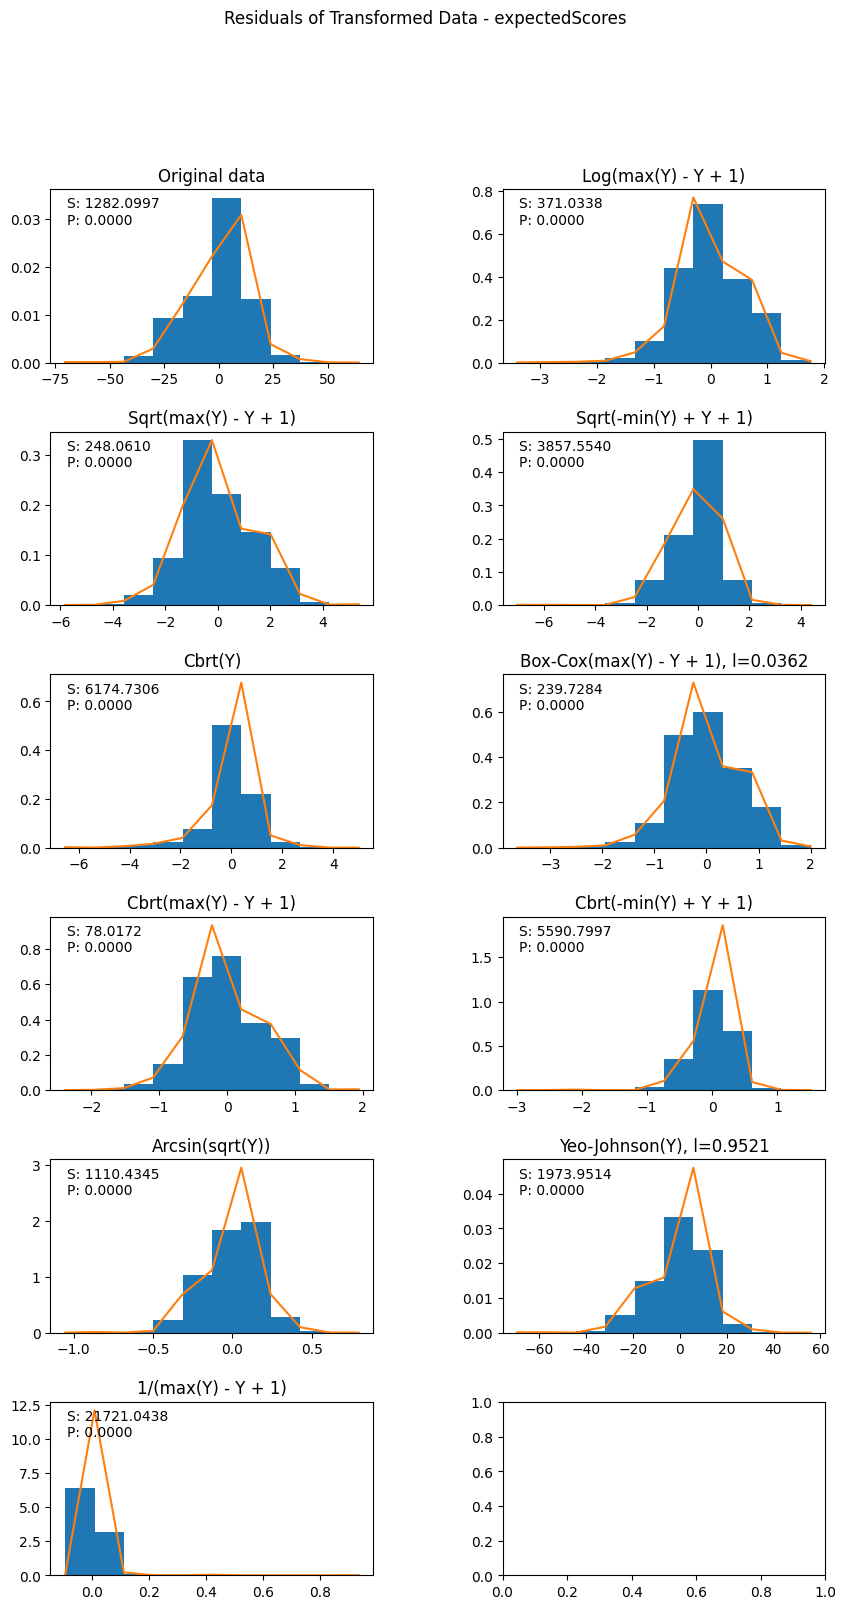

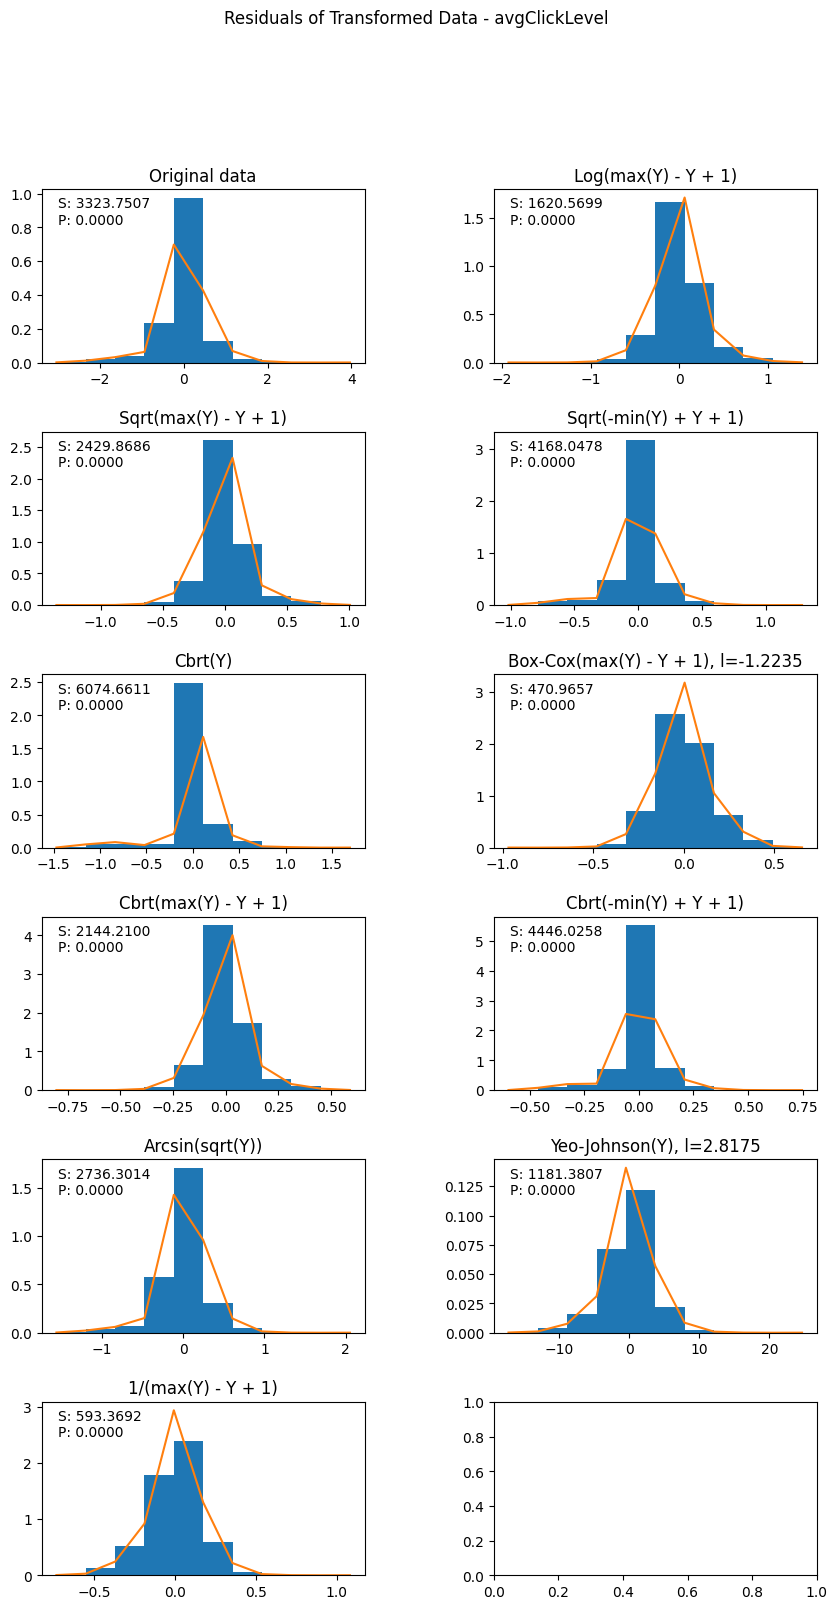

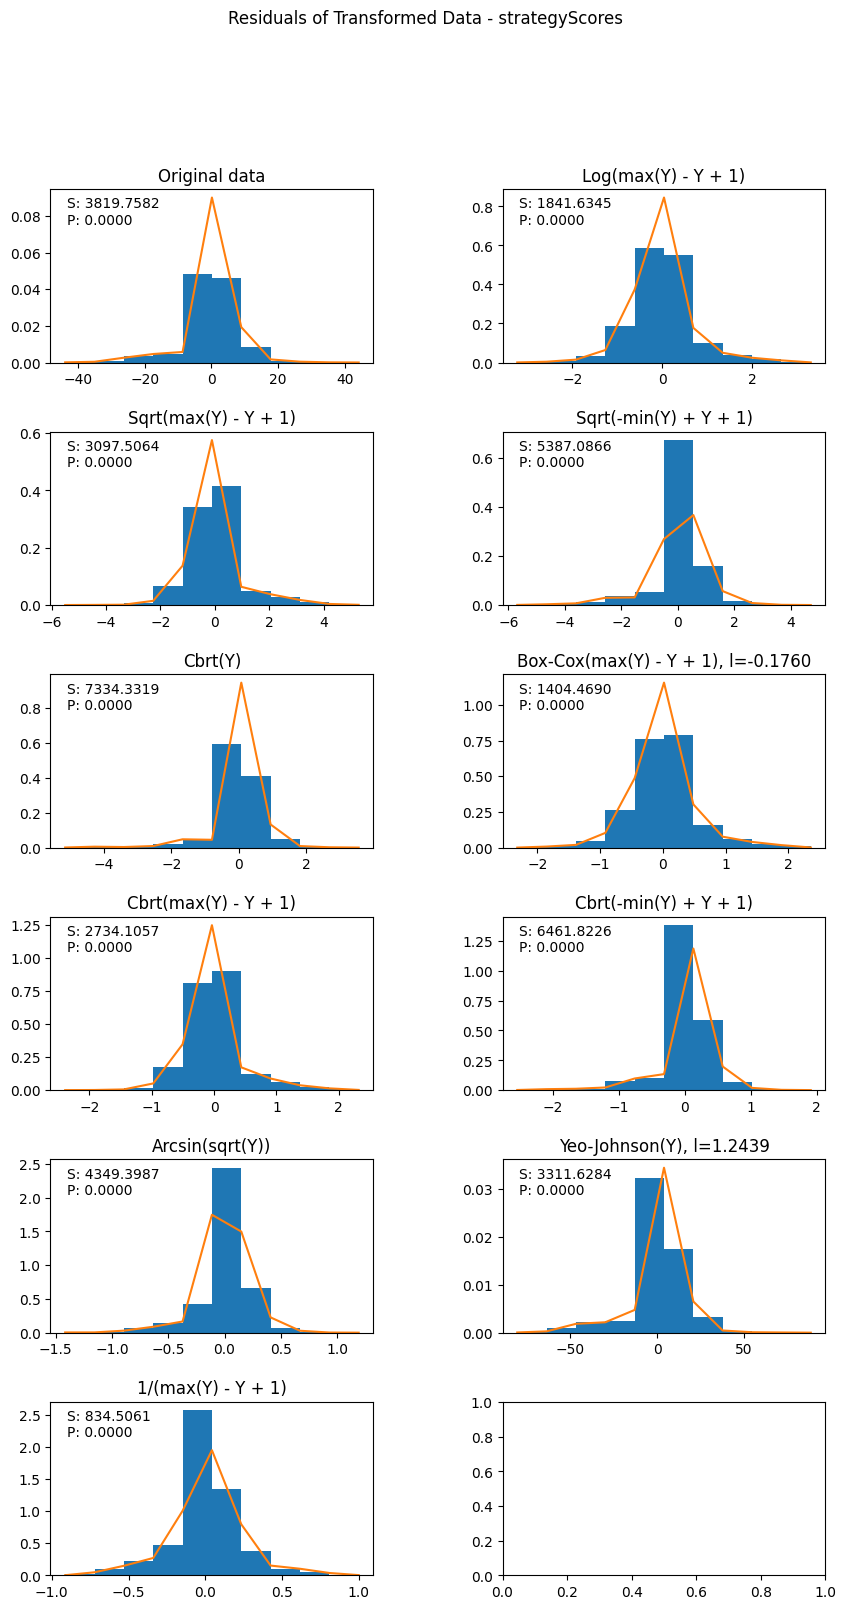

In [334]:
# Plotting residuals for all GLM Models

analysis_cols = {res: [] for res in response_vars}
highest_normality_trans = {res: "" for res in response_vars}

for response_var in response_vars:
    fig, ax = plt.subplots(nrows=math.ceil(len(all_residuals[response_var])/2),ncols=2,figsize=(10, 3 * math.ceil(len(all_residuals[response_var])/2)),squeeze=False)
    plt.suptitle("Residuals of Transformed Data - {}".format(response_var))
    ax = ax.flatten()

    lowest_normality_stat = float("inf")
    for idx, trans in enumerate(all_residuals[response_var]):
        resids = trans[0]
        response_data = trans[1]
        label = trans[2]
        normaltest = trans[3]
        if normaltest.statistic < lowest_normality_stat:
            analysis_cols[response_var] = response_data
            highest_normality_trans[response_var] = label
            lowest_normality_stat = normaltest.statistic
        density = scipy.stats.gaussian_kde(resids)
        n, x, _ = ax[idx].hist(resids, density=True)
        ax[idx].set_title(label)
        ax[idx].plot(x, density(x))
        ax[idx].text(0.05,0.8, "S: {0:0.4f}\nP: {1:0.4f}".format(normaltest.statistic, normaltest.pvalue), transform=ax[idx].transAxes)

    plt.subplots_adjust(
                    wspace=0.4, 
                    hspace=0.4)
plt.show()

In [335]:
# data which is to be used for the remainder of the analysis

# Displaying which of the data has the most normal residuals 
analysis_data = transformed_trials_df.copy()
for response_var in response_vars:
    print("{} - {}".format(response_var, highest_normality_trans[response_var]))
    analysis_data[response_var] = analysis_cols[response_var]
    

expectedScores - Cbrt(max(Y) - Y + 1)
avgClickLevel - Box-Cox(max(Y) - Y + 1), l=-1.2235
strategyScores - 1/(max(Y) - Y + 1)


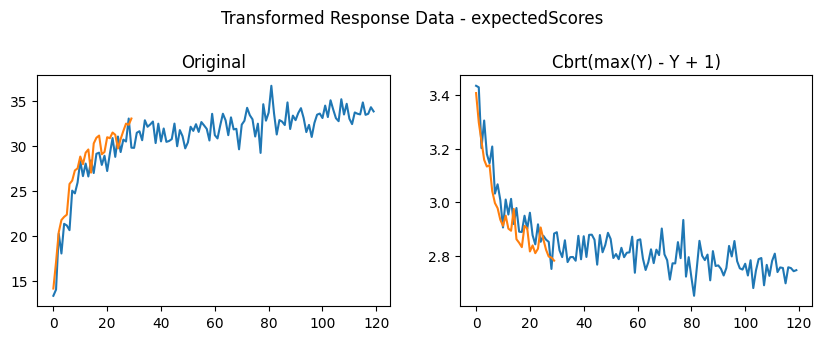

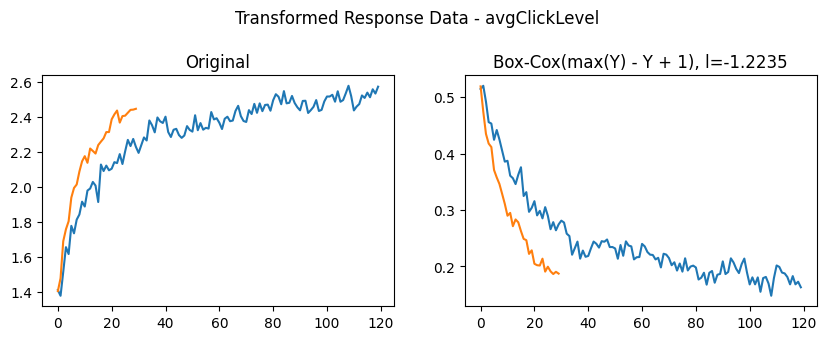

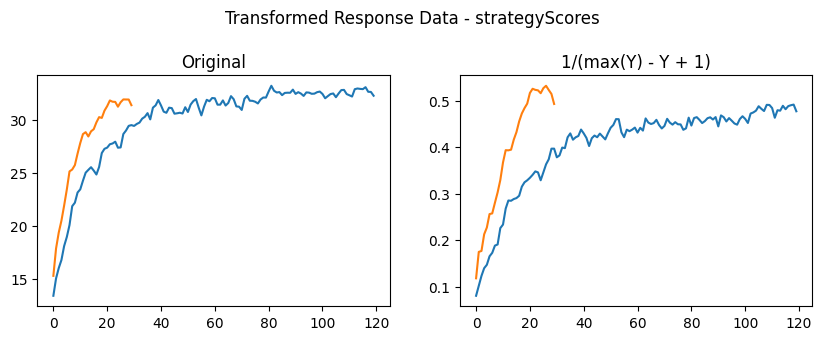

In [336]:
# Visualize transformed data for each response variable

for response_var in response_vars:
    fig, ax = plt.subplots(nrows=1,ncols=2,figsize=(10, 3),squeeze=True)
    plt.suptitle("Transformed Response Data - {}".format(response_var),y=1.1)
    ax = ax.flatten()

    for idx, trans in enumerate([transformed_trials_df, analysis_data]):
        data = trans
        scarce = data.loc[data.scarce == 1]
        control = data.loc[data.scarce == 0]
        label = "Original" if idx == 0 else highest_normality_trans[response_var]

        scarce_mean = np.array(scarce.groupby('trialNumbers').mean()[response_var])
        control_mean = np.array(control.groupby('trialNumbers').mean()[response_var])
        ax[idx].plot(list(range(len(scarce_mean))), scarce_mean, label="Scarce")
        ax[idx].plot(list(range(len(control_mean))), control_mean, label="Control")
        ax[idx].set_title(label)

plt.show()

# 1.1.1 - Linear Regression: Finding Best Model of Learning vs. Performance

Used to compute partitions between fast learning phase and slow improvement phase for each condition

### Finding Best Model for Scarce Condition

In [337]:


test_df = analysis_data

mixed = False
    
# For scarce trials
relevant_trials = test_df.loc[test_df.scarce == 1].copy()

all_trials_mean_scarce = relevant_trials.groupby("trialNumbers").mean()["expectedScores"]
all_trial_nos_scarce = list(range(1,len(all_trials_mean_scarce)+1))

sig_bic_scores_scarce = []
scarce_plot_data = []
scarce_glm_results = []

# Check all possible data splits for both conditions
for trialNum in range(2,60,1):
    isPerformanceTrial = [int(trial > trialNum) for trial in relevant_trials.trialNumbers]
    relevant_trials['isPerformanceTrial'] = isPerformanceTrial
    
    partition_1_df = relevant_trials.loc[relevant_trials.isPerformanceTrial == 0]
    partition_2_df = relevant_trials.loc[relevant_trials.isPerformanceTrial == 1]
    partition_1_mean_scores = partition_1_df.groupby("trialNumbers").mean()["expectedScores"]
    partition_2_mean_scores = partition_2_df.groupby("trialNumbers").mean()["expectedScores"]
    
    two_slope_formula = "expectedScores ~ trialNumbers + trialNumbers:C(isPerformanceTrial) + C(isPerformanceTrial)"
    one_slope_formula = "expectedScores ~ trialNumbers"
    
    # Fitting a single-slope model and a two-slope model to see which is better
    if mixed:
        glm_1 = smf.mixedlm(formula=two_slope_formula, data=relevant_trials, groups=relevant_trials['workerId'])
        glm_2 = smf.mixedlm(formula=one_slope_formula, data=relevant_trials, groups=relevant_trials['workerId'])
    else:
        glm_1 = smf.glm(formula=two_slope_formula, data=relevant_trials)
        glm_2 = smf.glm(formula=one_slope_formula, data=relevant_trials)

    try:
        results_1 = glm_1.fit()
        results_2 = glm_2.fit()
    except:
        continue
        
    bic1 = results_1.bic_llf
    bic2 = results_2.bic_llf
        
    # Saving the slopes and the single intercept of both phases from the two-slope model
    b1 = results_1.params['trialNumbers']
    b2 = results_1.params['trialNumbers'] + results_1.params['trialNumbers:C(isPerformanceTrial)[T.1]']
    i1 = results_1.params['Intercept']
    i2 = results_1.params['Intercept'] + results_1.params['C(isPerformanceTrial)[T.1]']
    
    b3 = results_2.params['trialNumbers']
    i3 = results_2.params['Intercept']
    
    if(bic1 < bic2):
        # Save data about significant partitions, where the bic of the two-slope model is higher than one-slope
        sig_bic_scores_scarce.append((trialNum, bic1))
        
    x1 = all_trial_nos_scarce[0:len(partition_1_mean_scores)]
    x2 = all_trial_nos_scarce[len(partition_1_mean_scores):len(partition_1_mean_scores)+len(partition_2_mean_scores)]
    scarce_plot_data.append((
        trialNum,
        x1,
        x2,
        partition_1_mean_scores,
        partition_2_mean_scores,
        b1,
        b2,
        i1,
        i2,
        b3,
        i3,
        partition_1_df,
        partition_2_df
    ))
    scarce_glm_results.append((trialNum, results_1, results_2))

Partition candidates: 
[13.]


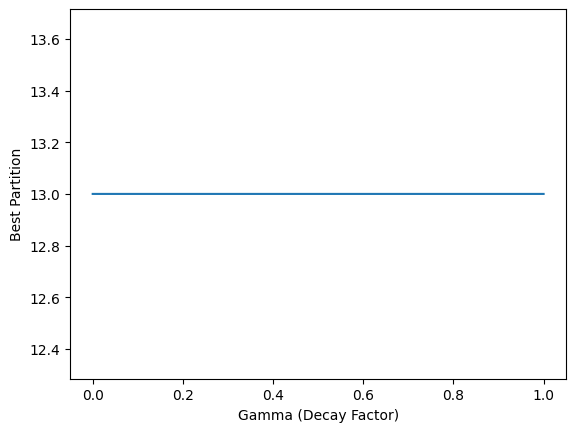

In [338]:
# Finding the best partition of all significant ones 
if use_model_data:
    partition_candidates = [13] # Use partition from human dataset
else:
    sig_bic_scores_scarce = np.array(sig_bic_scores_scarce)

    g_range = np.arange(0, 1, 0.0001)
    best_partitions = []

    for gamma in g_range:
        # Minimum bic
        partition_scores = sig_bic_scores_scarce[:,1]
        best_partition = sig_bic_scores_scarce[np.argmin(partition_scores),0]
        best_partitions.append(best_partition)

    partition_candidates = np.unique(best_partitions)



    print("Partition candidates: ")
    print(partition_candidates)
    plt.plot(g_range, best_partitions)
    plt.xlabel("Gamma (Decay Factor)")
    plt.ylabel("Best Partition")
    plt.show()


In [339]:
# Showing GLM results - scarce
candidate_glm_results_scarce = [data for data in scarce_glm_results if float(data[0]) in partition_candidates]

for trialNum, results_1, results_2 in candidate_glm_results_scarce:
    print("Trial Num: {}".format(trialNum))
    print("\nTwo-Slope Model:\nBIC LLF: {0:0.4f}\n\nBIC Deviance: {1:0.4f}\n\nAIC: {2:0.4f}\n"
          .format(results_1.bic_llf,results_1.bic_deviance, results_1.aic))
    print(results_1.summary())
    
    print("\nOne-Slope Model:\nBIC LLF: {0:0.4f}\n\nBIC Deviance: {1:0.4f}\n\nAIC: {2:0.4f}\n"
          .format(results_2.bic_llf,results_2.bic_deviance, results_2.aic))
    print(results_2.summary())


Trial Num: 13

Two-Slope Model:
BIC LLF: 25601.4879

BIC Deviance: -113313.7683

AIC: 25571.7221

                 Generalized Linear Model Regression Results                  
Dep. Variable:         expectedScores   No. Observations:                12600
Model:                            GLM   Df Residuals:                    12596
Model Family:                Gaussian   Df Model:                            3
Link Function:               identity   Scale:                         0.44544
Method:                          IRLS   Log-Likelihood:                -12782.
Date:                Mon, 23 Jan 2023   Deviance:                       5610.8
Time:                        21:57:27   Pearson chi2:                 5.61e+03
No. Iterations:                     3   Pseudo R-squ. (CS):            0.03361
Covariance Type:            nonrobust                                         
                                              coef    std err          z      P>|z|      [0.025      0.975]
----

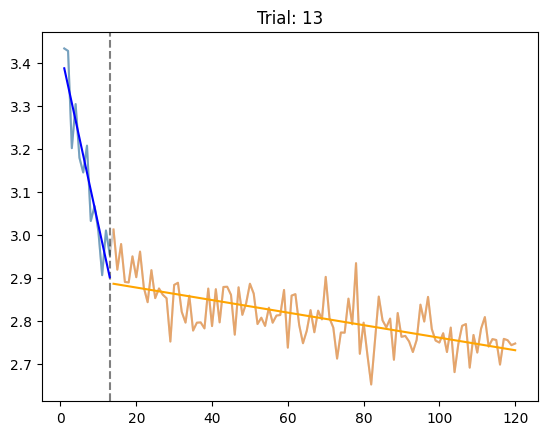

In [340]:
# Plotting candidate partitions - scarce
candidate_plot_data_scarce = [data for data in scarce_plot_data if float(data[0]) in partition_candidates]
#significant_plot_data_scarce = [data for data in scarce_plot_data if float(data[0]) in sig_bic_scores_scarce[:,0]]

which_plot = "candidates" #all, significant, candidates

if which_plot == "candidates":
    plot_data = candidate_plot_data_scarce
elif which_plot == "significant":
    plot_data = significant_plot_data_scarce
else:
    plot_data = scarce_plot_data
    
plot_single_slope = False
plot_two_slope = True
scatter = False
error = False

for trialNum, x1, x2, y1, y2, b1, b2, i1, i2,b3, i3, df_1, df_2 in plot_data:
    plt.figure()
    # Expected Score curves
    plt.plot(all_trial_nos_scarce, all_trials_mean_scarce, alpha=0.2, color='k')
    plt.plot(x1, y1, alpha=0.5)
    plt.plot(x2, y2, alpha=0.5)
    
    # Scatter points
    if scatter:
        plt.scatter(df_1['trialNumbers'], df_1['expectedScores'], color='b', marker='o', alpha=0.1,s=0.8)
        plt.scatter(df_2['trialNumbers'], df_2['expectedScores'], color='orange', marker='o', alpha=0.1,s=0.8)

    # Partition line
    plt.axvline(trialNum, linestyle="--", color='k',alpha=0.5)

    # Slope lines of one-slope model
    if plot_single_slope:
        x3 = np.concatenate([x1,x2],axis=0)
        plt.plot(x3, np.array(x3) * b3 + i3, color='g', alpha=0.5)
    
    if plot_two_slope:
        # Slope lines of two-slope model
        plt.plot(x1, np.array(x1) * b1 + i1, color='b')
        plt.plot(x2, np.array(x2) * b2 + i2, color='orange')
        
    if error:
        plt.fill_between(x1, scarce_data_all + scarce_data_all_sd, scarce_data_all - scarce_data_all_sd, alpha=0.1)
    
    plt.title("Trial: {}".format(trialNum))
    
plt.show()

In [341]:
scarce_partition = partition_candidates[0] # Somehow choose based on possible candidates

# Separating into learning and performance phase
scarce_learning_data = analysis_data.loc[(analysis_data.scarce == 1) & (analysis_data.trialNumbers <= scarce_partition)]
scarce_performance_data = analysis_data.loc[(analysis_data.scarce ==1) & (analysis_data.trialNumbers > scarce_partition)]

# Without transformation
scarce_learning_data_orig = filtered_data.loc[(filtered_data.scarce == 1) & (filtered_data.trialNumbers <= scarce_partition)]
scarce_performance_data_orig = filtered_data.loc[(filtered_data.scarce ==1) & (filtered_data.trialNumbers > scarce_partition)]

# Store the slope, intercept, etc. of the best partition
scarce_partition_plot_data = [data for data in candidate_plot_data_scarce if data[0] == scarce_partition][0]

### Finding Best Model for Control Condition

In [342]:
# GLM 3 - finding cut off point of learning phase

test_df = analysis_data

mixed = False
    
# For control trials
relevant_trials = test_df.loc[test_df.scarce == 0].copy()

all_trials_mean_control = relevant_trials.groupby("trialNumbers").mean()["expectedScores"]
all_trial_nos_control = list(range(1,len(all_trials_mean_control)+1))

sig_bic_scores_control = []
control_plot_data = []
control_glm_results = []
for trialNum in range(2,30,1):
    isPerformanceTrial = [int(trial > trialNum) for trial in relevant_trials.trialNumbers]
    relevant_trials['isPerformanceTrial'] = isPerformanceTrial
    
    partition_1_df = relevant_trials.loc[relevant_trials.isPerformanceTrial == 0]
    partition_2_df = relevant_trials.loc[relevant_trials.isPerformanceTrial == 1]
    partition_1_mean_scores = partition_1_df.groupby("trialNumbers").mean()["expectedScores"]
    partition_2_mean_scores = partition_2_df.groupby("trialNumbers").mean()["expectedScores"]
    
    two_slope_formula = "expectedScores ~ trialNumbers + C(scarce) + C(isPerformanceTrial) + trialNumbers:C(isPerformanceTrial)"
    one_slope_formula = "expectedScores ~ trialNumbers + C(scarce)"
    
    # Fitting a single-slope model and a two-slope model to see which is better
    if mixed:
        glm_1 = smf.mixedlm(formula=two_slope_formula, data=relevant_trials, groups=relevant_trials['workerId'])
        glm_2 = smf.mixedlm(formula=one_slope_formula, data=relevant_trials, groups=relevant_trials['workerId'])
    else:
        glm_1 = smf.glm(formula=two_slope_formula, data=relevant_trials)
        glm_2 = smf.glm(formula=one_slope_formula, data=relevant_trials)

    try:
        results_1 = glm_1.fit()
        results_2 = glm_2.fit()
    except:
        continue
        
    bic1 = results_1.bic_llf
    bic2 = results_2.bic_llf
    
    # print(results_1.summary())
    
    # Saving the slopes and the single intercept of both phases from the two-slope model
    b1 = results_1.params['trialNumbers']
    b2 = results_1.params['trialNumbers'] + results_1.params['trialNumbers:C(isPerformanceTrial)[T.1]']
    i1 = results_1.params['Intercept']
    i2 = results_1.params['Intercept'] + results_1.params['C(isPerformanceTrial)[T.1]']
    
    b3 = results_2.params['trialNumbers']
    i3 = results_2.params['Intercept']
    if(bic1 < bic2):
        # Save data about significant partitions, where the bic of the two-slope model is higher than one-slope
        sig_bic_scores_control.append((trialNum, bic1))
        
    x1 = all_trial_nos_control[0:len(partition_1_mean_scores)]
    x2 = all_trial_nos_control[len(partition_1_mean_scores):len(partition_1_mean_scores)+len(partition_2_mean_scores)]
    control_plot_data.append((
        trialNum,
        x1,
        x2,
        partition_1_mean_scores,
        partition_2_mean_scores,
        b1,
        b2,
        i1,
        i2,
        b3, 
        i3,
        partition_1_df,
        partition_2_df
    ))
    control_glm_results.append((trialNum, results_1, results_2))

In [343]:
sig_bic_scores_control

[(2, 6549.925373357226),
 (3, 6545.646423491274),
 (4, 6543.467411096814),
 (5, 6541.528895409941),
 (6, 6538.4751632283815),
 (7, 6537.524484368611),
 (8, 6537.215022852198),
 (9, 6537.192410541495),
 (10, 6537.341722608419),
 (11, 6537.609654721525),
 (12, 6539.461302837822),
 (13, 6540.322977911982),
 (14, 6541.464785313489),
 (15, 6545.368722183919),
 (16, 6545.865261219032),
 (17, 6546.324657387127),
 (18, 6546.413013597058),
 (19, 6550.466639573863)]

Partition candidates: 
[9.]


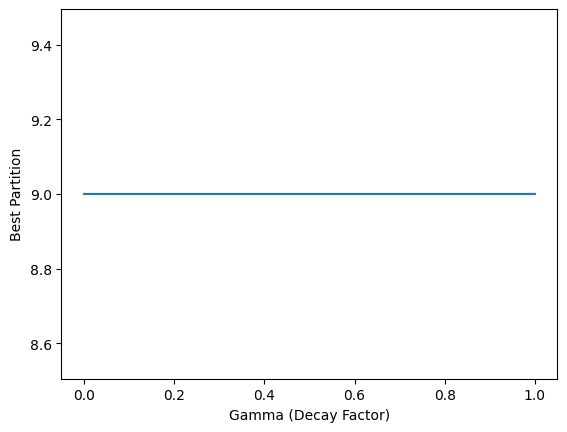

In [344]:
# Finding the best partition of all significant ones 

if use_model_data:
    partition_candidates = [9] # Use partition from human data
else:
    sig_bic_scores_control = np.array(sig_bic_scores_control)

    g_range = np.arange(0, 1, 0.0001)
    best_partitions = []

    for gamma in g_range:
        # Minimum bic
        partition_scores = sig_bic_scores_control[:,1]
        best_partition = sig_bic_scores_control[np.argmin(partition_scores),0]
        best_partitions.append(best_partition)

    partition_candidates = np.unique(best_partitions)
    print("Partition candidates: ")
    print(partition_candidates)
    plt.plot(g_range, best_partitions)
    plt.xlabel("Gamma (Decay Factor)")
    plt.ylabel("Best Partition")
    plt.show()


In [345]:
# Showing GLM results - control
candidate_glm_results_control = [data for data in control_glm_results if float(data[0]) in partition_candidates]

for trialNum, results_1, results_2 in candidate_glm_results_control:
    print("Trial Num: {}".format(trialNum))
    print("\nTwo-Slope Model:\nBIC LLF: {0:0.4f}\n\nBIC Deviance: {1:0.4f}\n\nAIC: {2:0.4f}\n"
          .format(results_1.bic_llf,results_1.bic_deviance, results_1.aic))
    print(results_1.summary())
    
    print("\nOne-Slope Model:\nBIC LLF: {0:0.4f}\n\nBIC Deviance: {1:0.4f}\n\nAIC: {2:0.4f}\n"
          .format(results_2.bic_llf,results_2.bic_deviance, results_2.aic))
    print(results_2.summary())


Trial Num: 9

Two-Slope Model:
BIC LLF: 6537.1924

BIC Deviance: -23313.7604

AIC: 6513.0487

                 Generalized Linear Model Regression Results                  
Dep. Variable:         expectedScores   No. Observations:                 3090
Model:                            GLM   Df Residuals:                     3086
Model Family:                Gaussian   Df Model:                            3
Link Function:               identity   Scale:                         0.48124
Method:                          IRLS   Log-Likelihood:                -3252.5
Date:                Mon, 23 Jan 2023   Deviance:                       1485.1
Time:                        21:57:29   Pearson chi2:                 1.49e+03
No. Iterations:                     3   Pseudo R-squ. (CS):            0.04783
Covariance Type:            nonrobust                                         
                                              coef    std err          z      P>|z|      [0.025      0.975]
--------

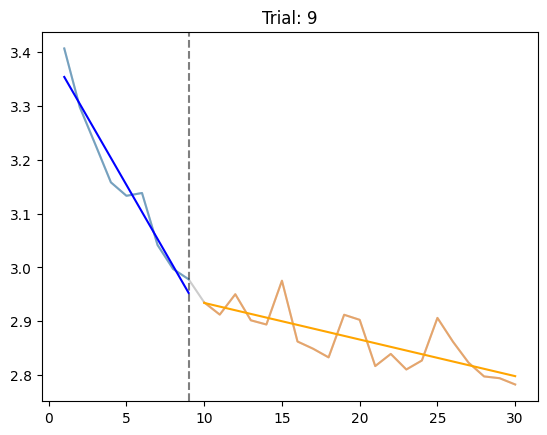

In [346]:
# Plotting candidate partitions - control
candidate_plot_data_control = [data for data in control_plot_data if float(data[0]) in partition_candidates]
#significant_plot_data_control = [data for data in control_plot_data if float(data[0]) in sig_bic_scores_control[:,0]]

which_plot = "candidates" #all, significant, candidates

if which_plot == "candidates":
    plot_data = candidate_plot_data_control
elif which_plot == "significant":
    plot_data = significant_plot_data_control
else:
    plot_data = control_plot_data
    
plot_single_slope = False
plot_two_slope = True
scatter = False

for trialNum, x1, x2, y1, y2, b1, b2, i1, i2,b3, i3, df_1, df_2 in plot_data:
    plt.figure()
    # Expected Score curves
    plt.plot(all_trial_nos_control, all_trials_mean_control, alpha=0.2, color='k')
    plt.plot(x1, y1, alpha=0.5)
    plt.plot(x2, y2, alpha=0.5)

    # Partition line
    plt.axvline(trialNum, linestyle="--", color='k',alpha=0.5)
    
    # Scatter points
    if scatter:
        plt.scatter(df_1['trialNumbers'], df_1['expectedScores'], color='b', marker='o', alpha=0.1,s=0.8)
        plt.scatter(df_2['trialNumbers'], df_2['expectedScores'], color='orange', marker='o', alpha=0.1,s=0.8)

    # Slope lines of one-slope model
    if plot_single_slope:
        x3 = np.concatenate([x1,x2],axis=0)
        plt.plot(x3, np.array(x3) * b3 + i3, color='g', alpha=0.5)
    
    if plot_two_slope:
        # Slope lines of two-slope model
        plt.plot(x1, np.array(x1) * b1 + i1, color='b')
        plt.plot(x2, np.array(x2) * b2 + i2, color='orange')
    
    plt.title("Trial: {}".format(trialNum))
    
plt.show()

In [347]:
control_partition = partition_candidates[0] # Somehow choose based on possible candidates

# Separating into learning and performance phase
control_learning_data = analysis_data.loc[(analysis_data.scarce == 0) & (analysis_data.trialNumbers <= control_partition)]
control_performance_data = analysis_data.loc[(analysis_data.scarce == 0) & (analysis_data.trialNumbers > control_partition)]

# Without transformation
control_learning_data_orig = filtered_data.loc[(filtered_data.scarce == 0) & (filtered_data.trialNumbers <= control_partition)]
control_performance_data_orig = filtered_data.loc[(filtered_data.scarce == 0) & (filtered_data.trialNumbers > control_partition)]

# Store the slope, intercept, etc. of the best partition
control_partition_plot_data = [data for data in candidate_plot_data_control if data[0] == control_partition][0]

# 1.2 - Linear Regression: Response Var vs. Trial Number x Condition

Results for response variable "expectedScores" reported in paper

In [348]:
# Select the response variable for this analysis

response_var = "expectedScores"
assert (response_var in response_vars), "{} is not a valid response variable".format(response_var)

In [349]:
# Flag to compare entire performance data or only upto 30 trials, where both conditions are comparable

compare_all = True
num_max_trials = min(
    analysis_data[analysis_data.scarce==1].trialNumbers.max(),
    analysis_data[analysis_data.scarce==0].trialNumbers.max()
)

                 Mixed Linear Model Regression Results
Model:                 MixedLM    Dependent Variable:    expectedScores
No. Observations:      2292       Method:                REML          
No. Groups:            208        Scale:                 196.1879      
Min. group size:       9          Log-Likelihood:        -9559.1139    
Max. group size:       13         Converged:             Yes           
Mean group size:       11.0                                            
-----------------------------------------------------------------------
                             Coef.  Std.Err.   z    P>|z| [0.025 0.975]
-----------------------------------------------------------------------
Intercept                    14.345    1.720  8.341 0.000 10.974 17.716
C(scarce)[T.1]               -0.579    2.349 -0.247 0.805 -5.184  4.025
trialNumbers                  1.515    0.178  8.502 0.000  1.166  1.864
trialNumbers:C(scarce)[T.1]  -0.319    0.205 -1.557 0.119 -0.721  0.083
Group Var

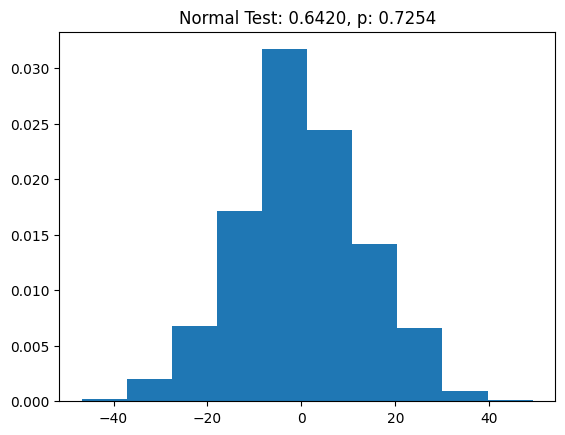

In [350]:
# Learning Phase

use_orig = True

if use_orig:
    learning_df = pd.concat([scarce_learning_data_orig, control_learning_data_orig]).reset_index(drop=True)
else: 
    learning_df = pd.concat([scarce_learning_data, control_learning_data]).reset_index(drop=True)

# Compare only the first 30 trials
if not compare_all:
    learning_df = learning_df.loc[learning_df.trialNumbers <= num_max_trials]

formula = '{} ~ trialNumbers + C(scarce) + trialNumbers:C(scarce)'.format(response_var)

mixed = True

if mixed:
    glm = smf.mixedlm(formula=formula, data=learning_df, groups=learning_df['workerId'])
else:
    glm = smf.glm(formula=formula, data=learning_df)

results = glm.fit()

print(results.summary())
resids = results.resid_response if not mixed else results.resid
normaltest = scipy.stats.normaltest(resids)
plt.hist(resids, density=True)
plt.title("Normal Test: {0:0.4f}, p: {1:0.4f}".format(normaltest[0], normaltest[1]))
plt.show()

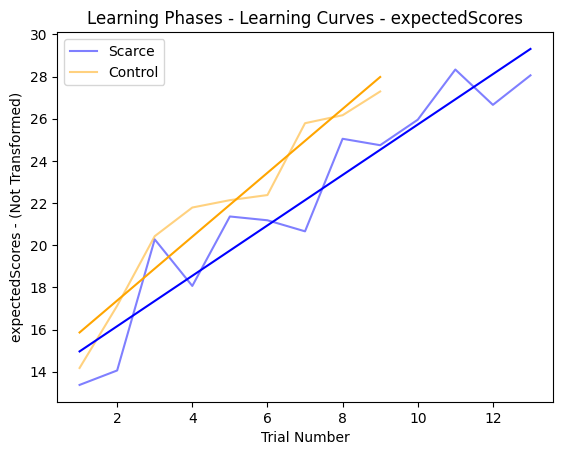

In [351]:
# Plotting the data of both learning phases

x1 = control_partition_plot_data[1]
x2 = scarce_partition_plot_data[1]
y1 = learning_df[learning_df.scarce==0].groupby("trialNumbers").mean()[response_var]
y2 = learning_df[learning_df.scarce==1].groupby("trialNumbers").mean()[response_var]
b1 = results.params['trialNumbers']
b2 = results.params['trialNumbers'] + results.params['trialNumbers:C(scarce)[T.1]']
i1 = results.params['Intercept']
i2 = results.params['Intercept'] + results.params['C(scarce)[T.1]']

plt.plot(x2, y2, color='b', alpha=0.5, label="Scarce")
plt.plot(x1, y1, color='orange', alpha=0.5, label="Control")


# Slope lines
plt.plot(x1, np.array(x1) * b1 + i1, color='orange')
plt.plot(x2, np.array(x2) * b2 + i2, color='b')
plt.title("Learning Phases - Learning Curves - {}".format(response_var))
plt.xlabel("Trial Number")
plt.ylabel("{} - {}".format(response_var, "(Not Transformed)" if use_orig else "(Transformed)"))
plt.legend()


plt.show()



                 Mixed Linear Model Regression Results
Model:                 MixedLM    Dependent Variable:    expectedScores
No. Observations:      13398      Method:                REML          
No. Groups:            208        Scale:                 179.0571      
Min. group size:       21         Log-Likelihood:        -54161.9251   
Max. group size:       107        Converged:             Yes           
Mean group size:       64.4                                            
-----------------------------------------------------------------------
                             Coef.  Std.Err.   z    P>|z| [0.025 0.975]
-----------------------------------------------------------------------
Intercept                    25.931    1.606 16.148 0.000 22.783 29.078
C(scarce)[T.1]                3.058    2.057  1.486 0.137 -0.975  7.090
trialNumbers                  0.217    0.048  4.572 0.000  0.124  0.310
trialNumbers:C(scarce)[T.1]  -0.172    0.048 -3.609 0.000 -0.266 -0.079
Group Var

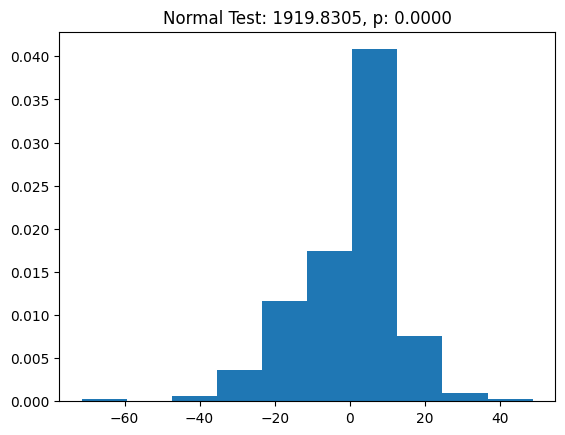

In [352]:
# Performance Phase

use_orig = True

if use_orig:
    performance_df = pd.concat([scarce_performance_data_orig, control_performance_data_orig]).reset_index(drop=True)
else: 
    performance_df = pd.concat([scarce_performance_data, control_performance_data]).reset_index(drop=True)

if not compare_all:
    performance_df = performance_df.loc[performance_df.trialNumbers <= num_max_trials]
    
formula = '{} ~ trialNumbers + C(scarce) + trialNumbers:C(scarce)'.format(response_var)

mixed = True

if mixed:
    glm = smf.mixedlm(formula=formula, data=performance_df, groups=performance_df['workerId'])
else:
    glm = smf.glm(formula=formula, data=performance_df)

results = glm.fit()

print(results.summary())
resids = results.resid_response if not mixed else results.resid
normaltest = scipy.stats.normaltest(resids)
plt.hist(resids, density=True)
plt.title("Normal Test: {0:0.4f}, p: {1:0.4f}".format(normaltest[0], normaltest[1]))
plt.show()

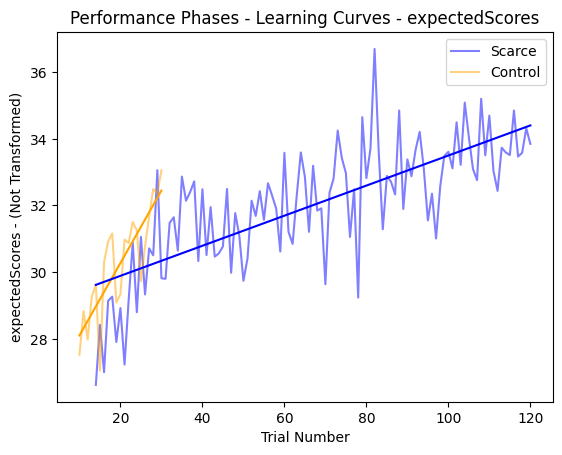

In [353]:
# Plotting the data of both performance phases together

x1 = control_partition_plot_data[2]
x2 = scarce_partition_plot_data[2]
y1 = performance_df[performance_df.scarce==0].groupby("trialNumbers").mean()[response_var]
y2 = performance_df[performance_df.scarce==1].groupby("trialNumbers").mean()[response_var]
b1 = results.params['trialNumbers']
b2 = results.params['trialNumbers'] + results.params['trialNumbers:C(scarce)[T.1]']
i1 = results.params['Intercept']
i2 = results.params['Intercept'] + results.params['C(scarce)[T.1]']

if not compare_all:
    end_index = np.where(x1 == num_max_trials)[0]
    if len(end_index) > 0:
        end_index = end_index[0]
        x1 = x1[0:end_index]
        y1 = y1[0:end_index]
    
    end_index = np.where(x2 == num_max_trials)[0]
    if len(end_index) > 0:
        end_index = end_index[0]
        x2 = x2[0:end_index]
        y2 = y2[0:end_index]
        

plt.plot(x2, y2, color='b', alpha=0.5, label="Scarce")
plt.plot(x1, y1, color='orange', alpha=0.5, label="Control")


# Slope lines
plt.plot(x1, np.array(x1) * b1 + i1, color='orange')
plt.plot(x2, np.array(x2) * b2 + i2, color='b')
plt.title("Performance Phases - Learning Curves - {}".format(response_var))
plt.xlabel("Trial Number")
plt.ylabel("{} - {}".format(response_var, "(Not Transformed)" if use_orig else "(Transformed)"))
plt.legend()

plt.show()

# 1.3 - Linear Regression: Response Var vs. Num Rewarded Trials

GLM Analysis for the effect of number of previously rewarded trials and previously unrewarded trials on improvement in response variable in each condition

(response_var) ~ numRewardedTrials + numUnrewardedTrials + condition + numRewardedTrials x condition

Results for response variable "expectedScores" reported in paper

In [354]:
# Select the response variable for this analysis

response_var = "expectedScores"
assert (response_var in response_vars), "{} is not a valid response variable".format(response_var)

In [355]:
# Flag to compare entire performance data or only upto 30 trials, where both conditions are comparable

compare_all = True
num_max_trials = min(
    analysis_data[analysis_data.scarce==1].trialNumbers.max(),
    analysis_data[analysis_data.scarce==0].trialNumbers.max()
)

                   Mixed Linear Model Regression Results
Model:                  MixedLM      Dependent Variable:      expectedScores
No. Observations:       2292         Method:                  REML          
No. Groups:             208          Scale:                   196.2527      
Min. group size:        9            Log-Likelihood:          -9558.6164    
Max. group size:        13           Converged:               Yes           
Mean group size:        11.0                                                
----------------------------------------------------------------------------
                                  Coef.  Std.Err.   z    P>|z| [0.025 0.975]
----------------------------------------------------------------------------
Intercept                         15.860    1.635  9.697 0.000 12.654 19.065
C(scarce)[T.1]                    -0.900    2.260 -0.398 0.690 -5.329  3.528
numRewardedTrials                  1.515    0.178  8.501 0.000  1.166  1.864
numRewardedTrials:C

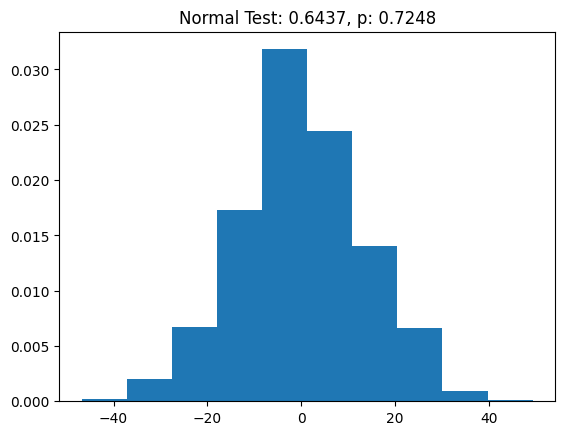

In [356]:
# Learning Phase 

use_orig = True

if use_orig:
    learning_df = pd.concat([scarce_learning_data_orig, control_learning_data_orig]).reset_index(drop=True)
else: 
    learning_df = pd.concat([scarce_learning_data, control_learning_data]).reset_index(drop=True)

if not compare_all:
    learning_df = learning_df.loc[learning_df.trialNumbers <= num_max_trials]
    
formula = '{} ~ numRewardedTrials + C(scarce) + numUnrewardedTrials + numRewardedTrials:C(scarce)'.format(response_var)

mixed = True

if mixed:
    glm = smf.mixedlm(formula=formula, data=learning_df, groups=learning_df['workerId'])
else:
    glm = smf.glm(formula=formula, data=learning_df)

results_learning = glm.fit()

print(results_learning.summary())
resids = results_learning.resid_response if not mixed else results_learning.resid
normaltest = scipy.stats.normaltest(resids)
plt.hist(resids, density=True)
plt.title("Normal Test: {0:0.4f}, p: {1:0.4f}".format(normaltest[0], normaltest[1]))
plt.show()

In [357]:
# comparing coefficients using contrasts

# between conditions
# H_a = numRewardedTrials - numUnrewardedTrials > 0
print("H_a = numRewardedTrials - numUnrewardedTrials > 0")
r = np.zeros_like(results_learning.params)
r[list(results_learning.params.index).index("numRewardedTrials")] = 1
r[list(results_learning.params.index).index("numUnrewardedTrials")] = -1

print(results_learning.t_test(np.expand_dims(r[:-1], axis=0)))
print(results_learning.f_test(r))
print(results_learning.wald_test(r))

# within scarce condition
# H_a = numRewardedTrials + numRewardedTrial:C(scarce)[T.1] - numUnrewardedTrials > 0
print("\nH_a = numRewardedTrials + numRewardedTrial:C(scarce)[T.1] - numUnrewardedTrials > 0")
r = np.zeros_like(results_learning.params)
r[list(results_learning.params.index).index("numRewardedTrials")] = 1
r[list(results_learning.params.index).index("numRewardedTrials:C(scarce)[T.1]")] = 1
r[list(results_learning.params.index).index("numUnrewardedTrials")] = -1
print(results_learning.t_test(np.expand_dims(r[:-1], axis=0)))
print(results_learning.f_test(r))
print(results_learning.wald_test(r))

H_a = numRewardedTrials - numUnrewardedTrials > 0
                             Test for Constraints                             
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
c0             0.3720      0.267      1.394      0.163      -0.151       0.895
<F test: F=1.9420102993112585, p=0.16358583037821883, df_denom=2.29e+03, df_num=1>
<Wald test (chi2): statistic=[[1.9420103]], p-value=0.16345042510437524, df_denom=1>

H_a = numRewardedTrials + numRewardedTrial:C(scarce)[T.1] - numUnrewardedTrials > 0
                             Test for Constraints                             
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
c0             0.1935      0.626      0.309      0.757      -1.033       1.420
<F test: F=0.0956128718063366, p=0.7571874359614779, df_denom=2.2

                   Mixed Linear Model Regression Results
Model:                  MixedLM      Dependent Variable:      expectedScores
No. Observations:       13398        Method:                  REML          
No. Groups:             208          Scale:                   178.9682      
Min. group size:        21           Log-Likelihood:          -54159.2324   
Max. group size:        107          Converged:               Yes           
Mean group size:        64.4                                                
----------------------------------------------------------------------------
                                  Coef.  Std.Err.   z    P>|z| [0.025 0.975]
----------------------------------------------------------------------------
Intercept                         26.148    1.578 16.570 0.000 23.055 29.241
C(scarce)[T.1]                     2.578    2.038  1.265 0.206 -1.417  6.572
numRewardedTrials                  0.217    0.048  4.573 0.000  0.124  0.310
numRewardedTrials:C

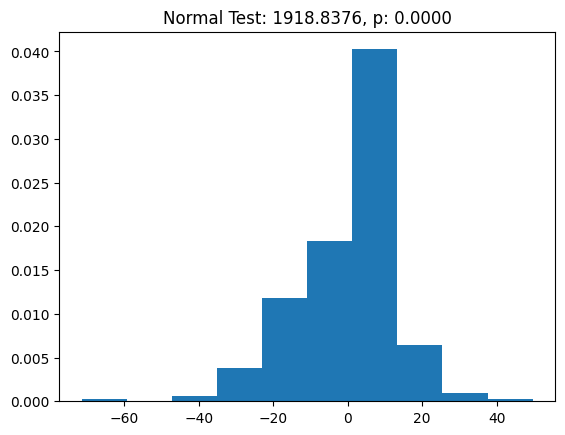

In [358]:
# Performance phase

use_orig = True

if use_orig:
    performance_df = pd.concat([scarce_performance_data_orig, control_performance_data_orig]).reset_index(drop=True)
else: 
    performance_df = pd.concat([scarce_performance_data, control_performance_data]).reset_index(drop=True)

if not compare_all:
    performance_df = performance_df.loc[performance_df.trialNumbers <= num_max_trials]
    
formula = '{} ~ numRewardedTrials + C(scarce) + numUnrewardedTrials + numRewardedTrials:C(scarce)'.format(response_var)

mixed = True

if mixed:
    glm = smf.mixedlm(formula=formula, data=performance_df, groups=performance_df['workerId'])
else:
    glm = smf.glm(formula=formula, data=performance_df)

results_performance = glm.fit()

print(results_performance.summary())
resids = results_performance.resid_response if not mixed else results_performance.resid
normaltest = scipy.stats.normaltest(resids)
plt.hist(resids, density=True)
plt.title("Normal Test: {0:0.4f}, p: {1:0.4f}".format(normaltest[0], normaltest[1]))
plt.show()

In [360]:
# comparing coefficients using contrasts

# between conditions
# H_a = numRewardedTrials - numUnrewardedTrials > 0
print("H_a = numRewardedTrials - numUnrewardedTrials > 0")
r = np.zeros_like(results_performance.params)
r[list(results_performance.params.index).index("numRewardedTrials")] = 1
r[list(results_performance.params.index).index("numUnrewardedTrials")] = -1

print(results_performance.t_test(np.expand_dims(r[:-1], axis=0)))
print(results_performance.f_test(r))
print(results_performance.wald_test(r))

# within scarce condition
# H_a = numRewardedTrials + numRewardedTrial:C(scarce)[T.1] - numUnrewardedTrials > 0
print("\nH_a = numRewardedTrials + numRewardedTrial:C(scarce)[T.1] - numUnrewardedTrials > 0")
r = np.zeros_like(results_performance.params)
r[list(results_performance.params.index).index("numRewardedTrials")] = 1
r[list(results_performance.params.index).index("numRewardedTrials:C(scarce)[T.1]")] = 1
r[list(results_performance.params.index).index("numUnrewardedTrials")] = -1
print(results_performance.t_test(np.expand_dims(r[:-1], axis=0)))
print(results_performance.f_test(r))
print(results_performance.wald_test(r))

H_a = numRewardedTrials - numUnrewardedTrials > 0
                             Test for Constraints                             
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
c0             0.2623      0.058      4.535      0.000       0.149       0.376
<F test: F=20.56548474127082, p=5.812583967519808e-06, df_denom=1.34e+04, df_num=1>
<Wald test (chi2): statistic=[[20.56548474]], p-value=5.762576472694613e-06, df_denom=1>

H_a = numRewardedTrials + numRewardedTrial:C(scarce)[T.1] - numUnrewardedTrials > 0
                             Test for Constraints                             
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
c0             0.3662      0.133      2.754      0.006       0.106       0.627
<F test: F=7.5846043727801495, p=0.005894828740316612, df_de

# 1.4 - Independent Samples T-test

Results for response variable "expectedScores" reported in paper

In [361]:
# Select the response variable for this analysis

response_var = "expectedScores"
assert (response_var in response_vars), "{} is not a valid response variable".format(response_var)

In [362]:
# Flag to compare entire performance data or only upto 30 trials, where both conditions are comparable

compare_all = False
num_max_trials = min(
    analysis_data[analysis_data.scarce==1].trialNumbers.max(),
    analysis_data[analysis_data.scarce==0].trialNumbers.max()
)

In [363]:
use_transformed = False

if not compare_all:
    control_performance_data = control_performance_data.loc[control_performance_data.trialNumbers <= num_max_trials]
    scarce_performance_data = scarce_performance_data.loc[scarce_performance_data.trialNumbers <= num_max_trials]

if use_transformed:
    # Using the transformed data divided into phases
    control_averages = control_performance_data.groupby('workerId').mean()
    scarce_averages = scarce_performance_data.groupby('workerId').mean()
else:
    # Using the original data divided into phases
    control_averages = control_performance_data_orig.groupby('workerId').mean()
    scarce_averages = scarce_performance_data_orig.groupby('workerId').mean()
    

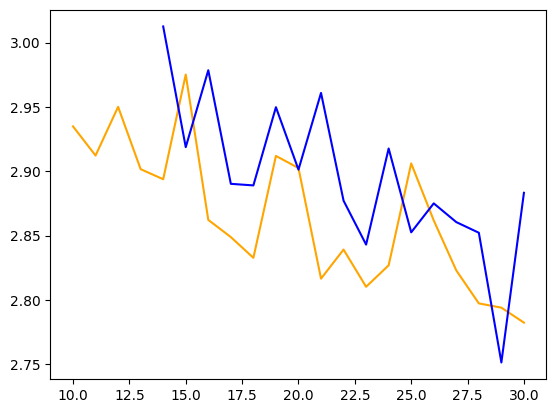

In [364]:
plt.figure()
plt.plot(np.sort(np.unique(control_performance_data.trialNumbers)), control_performance_data.groupby('trialNumbers').mean()[response_var], color='orange')
plt.plot(np.sort(np.unique(scarce_performance_data.trialNumbers)), scarce_performance_data.groupby('trialNumbers').mean()[response_var], color='b')
plt.show()

30.275080906148865 13.652829629137571
32.01023587004896 12.376307354792148


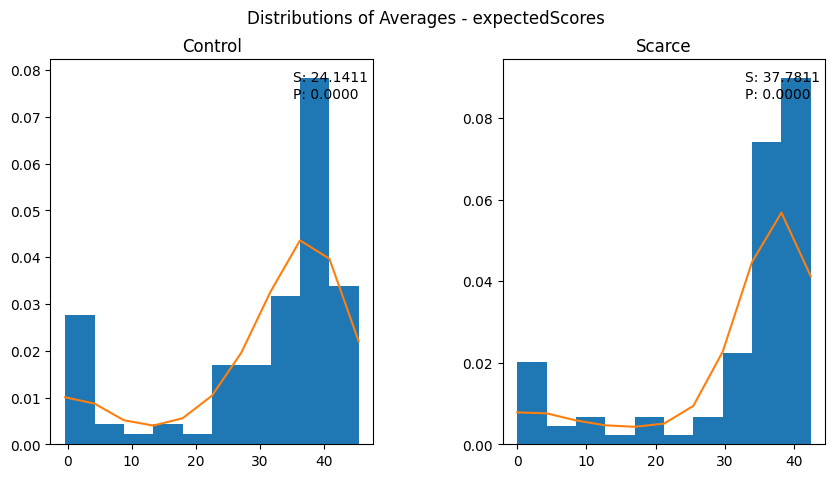

In [365]:

# Plotting normality for both groups

fig, ax = plt.subplots(nrows=1,ncols=2,figsize=(10, 5),squeeze=False)
plt.suptitle("Distributions of Averages - {}".format(response_var))
ax = ax.flatten()

for idx, group in enumerate([(control_averages, "Control"), (scarce_averages, "Scarce")]):
    data = group[0][response_var]
    label = group[1]
    print(data.mean(), data.std())
    normaltest = scipy.stats.normaltest(data)
    density = scipy.stats.gaussian_kde(data)
    n, x, _ = ax[idx].hist(data, density=True)
    ax[idx].set_title(label)
    ax[idx].plot(x, density(x))
    ax[idx].text(0.75,0.9, "S: {0:0.4f}\nP: {1:0.4f}".format(normaltest.statistic, normaltest.pvalue), transform=ax[idx].transAxes)

plt.subplots_adjust(
                wspace=0.4, 
                hspace=0.4)
plt.show()

In [245]:
# Perform independent T-test if data is normal


two = scipy.stats.ttest_ind(scarce_averages[response_var], control_averages[response_var], equal_var=True, alternative='two-sided')
less = scipy.stats.ttest_ind(scarce_averages[response_var], control_averages[response_var], equal_var=True, alternative='less')
greater = scipy.stats.ttest_ind(scarce_averages[response_var], control_averages[response_var], equal_var=True, alternative='greater')

print("Response Variable: {}".format(response_var))
print("Two-Sided:")
print("\tStatistic: {0:0.3f}\n\tP-value: {1}".format(two.statistic, two.pvalue))
print("Scarce < Control:")
print("\tStatistic: {0:0.3f}\n\tP-value: {1}".format(less.statistic, less.pvalue))
print("Scarce > Control:")
print("\tStatistic: {0:0.3f}\n\tP-value: {1}".format(greater.statistic, greater.pvalue))

Response Variable: expectedScores
Two-Sided:
	Statistic: 0.648
	P-value: 0.5175054588183226
Scarce < Control:
	Statistic: 0.648
	P-value: 0.7412472705908386
Scarce > Control:
	Statistic: 0.648
	P-value: 0.2587527294091613


In [246]:
# Perform Mann-Whitney U test if data is not normal

two = scipy.stats.mannwhitneyu(scarce_averages[response_var], control_averages[response_var], alternative='two-sided')
less = scipy.stats.mannwhitneyu(scarce_averages[response_var], control_averages[response_var], alternative='less')
greater = scipy.stats.mannwhitneyu(scarce_averages[response_var], control_averages[response_var], alternative='greater')

print("Two-Sided:")
print("\tStatistic: {0:0.3f}\n\tP-value: {1}".format(two.statistic, two.pvalue))
print("Scarce < Control:")
print("\tStatistic: {0:0.3f}\n\tP-value: {1}".format(less.statistic, less.pvalue))
print("Scarce > Control:")
print("\tStatistic: {0:0.3f}\n\tP-value: {1}".format(greater.statistic, greater.pvalue))

Two-Sided:
	Statistic: 5230.000
	P-value: 0.6615315144733205
Scarce < Control:
	Statistic: 5230.000
	P-value: 0.6701129758904127
Scarce > Control:
	Statistic: 5230.000
	P-value: 0.33076575723666024


# 1.6 - Stable Strategy Comparisons

Analysis to see which of the strategies participants converged on and whether they are the same in both conditions

Not reported in paper

In [213]:
filtered_data['strategy'] = filtered_data['strategy'].astype('int64')

In [214]:
# Strategies taken are from the latter 50% of the trials of each participant

# Take median of participant strategies or mode (most frequent)
measure = 'median' #median, mode

if measure == 'median':
    scarce_end_strat = filtered_data.loc[(filtered_data.scarce == 1) & (filtered_data.trialNumbers > 60)].groupby('workerId').median()['strategy'].astype('int64')
    control_end_strat = filtered_data.loc[(filtered_data.scarce == 0) & (filtered_data.trialNumbers > 15)].groupby('workerId').median()['strategy'].astype('int64')
elif measure == 'mode':
    scarce_end_strat = filtered_data.loc[(filtered_data.scarce == 1) & (filtered_data.trialNumbers > 60)].groupby('workerId')['strategy'].agg(pd.Series.mode)#.astype('int64')
    control_end_strat = filtered_data.loc[(filtered_data.scarce == 0) & (filtered_data.trialNumbers > 15)].groupby('workerId')['strategy'].agg(pd.Series.mode)#.astype('int64')

In [215]:
# Create contingency table

table = np.zeros((89,2))

for strat in scarce_end_strat:
    #print(type(strat))
    if type(strat) != int and type(strat) != np.int64:
        strat = strat[0]
    table[strat][1] += 1
    
for strat in control_end_strat:
    if type(strat) != int and type(strat) != np.int64:
        strat = strat[0]
    table[strat][0] += 1
    
table

array([[ 0.,  0.],
       [ 0.,  0.],
       [ 0.,  0.],
       [ 0.,  0.],
       [ 0.,  0.],
       [ 1.,  0.],
       [ 0.,  0.],
       [ 0.,  0.],
       [ 0.,  0.],
       [ 0.,  0.],
       [ 0.,  0.],
       [ 2.,  1.],
       [ 0.,  1.],
       [ 0.,  0.],
       [ 0.,  0.],
       [ 0.,  0.],
       [ 1.,  1.],
       [ 0.,  1.],
       [ 0.,  4.],
       [ 0.,  0.],
       [ 0.,  0.],
       [48., 34.],
       [ 1.,  0.],
       [ 0.,  0.],
       [ 0.,  1.],
       [ 0.,  0.],
       [ 5.,  8.],
       [ 4.,  3.],
       [ 2.,  1.],
       [ 0.,  0.],
       [ 7.,  7.],
       [ 8.,  5.],
       [ 0.,  1.],
       [ 0.,  0.],
       [ 0.,  0.],
       [ 0.,  0.],
       [ 0.,  0.],
       [ 1.,  0.],
       [ 0.,  0.],
       [ 0.,  0.],
       [ 3.,  2.],
       [ 0.,  0.],
       [ 1.,  4.],
       [ 1.,  3.],
       [ 0.,  1.],
       [ 0.,  0.],
       [ 0.,  2.],
       [ 0.,  0.],
       [ 0.,  0.],
       [ 0.,  0.],
       [ 1.,  4.],
       [ 0.,  0.],
       [ 0.,

In [216]:
# Perform chi square test of independence

summed_tab = table.sum(axis=1)
nz_rows = np.where(summed_tab != 0)[0]
new_table = table[nz_rows]



crosstab = pd.crosstab(new_table[:,0], new_table[:,1])
scipy.stats.chi2_contingency(new_table)


(37.14788229067282,
 0.2437497664233364,
 32,
 array([[ 0.49253731,  0.50746269],
        [ 1.47761194,  1.52238806],
        [ 0.49253731,  0.50746269],
        [ 0.98507463,  1.01492537],
        [ 0.49253731,  0.50746269],
        [ 1.97014925,  2.02985075],
        [40.3880597 , 41.6119403 ],
        [ 0.49253731,  0.50746269],
        [ 0.49253731,  0.50746269],
        [ 6.40298507,  6.59701493],
        [ 3.44776119,  3.55223881],
        [ 1.47761194,  1.52238806],
        [ 6.89552239,  7.10447761],
        [ 6.40298507,  6.59701493],
        [ 0.49253731,  0.50746269],
        [ 0.49253731,  0.50746269],
        [ 2.46268657,  2.53731343],
        [ 2.46268657,  2.53731343],
        [ 1.97014925,  2.02985075],
        [ 0.49253731,  0.50746269],
        [ 0.98507463,  1.01492537],
        [ 2.46268657,  2.53731343],
        [ 2.95522388,  3.04477612],
        [ 0.49253731,  0.50746269],
        [ 1.97014925,  2.02985075],
        [ 2.46268657,  2.53731343],
        [ 0.492537